# Housing Prices Prediction

## Summary
Just wanted to perform a quick analysis using Tensorflow and Keras to make a prediction on the House Prices dataset.  Many have done and contributed their exploratory data analyses in Kaggle.  Based on these analyses, the focus here is to perform some quick data transformation and feature engineering, follow by model training and prediction.  Finally, generating the submission csv for assessment in Kaggle.

I aim for this notebook to be short and not dwell in too much details on why certain parameters or models are selected.  Purpose is to build a deep learning neural network model that perform well in making predictions on unseen data with optimal hyperparameters.

---
## References
1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
2. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
3. https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition


---
## Importing Libraries

In [113]:
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import re
import random

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [114]:
import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/test.csv
../data/data_description.txt
../data/train.csv
../data/results.csv
../data/sample_submission.csv


---
## Helper Functions

1. **combineTrainTest** - For data transformation and feature engineering with needs to be applied to both Train and Test set consistently.
2. **splitTrainTest** - For splitting the combined dataset back to train and test after data transformation and feature engineering.
3. **plot_importances** - For showing the feature importances as determined by the model.
4. **plot_scatter** - Scatter plot of 2 variables in a table
5. **plot_pairs** - Pair plot of multi variables in a table
6. **seedeverything** - Setting the seed for reproducible results

In [115]:
def combineTrainTest(train, test, features):
    train = train[features]
    test = test[features]
    out = pd.concat([train, test])
    return out

def splitTrainTest(traintest, train, test, target):
    train = traintest.loc[train.index].join(train[target])
    test = traintest.loc[test.index]
    return train, test

def plot_importances(model, columns, top=20):
    importances = pd.Series(data=model.feature_importances_, index=columns).sort_values()

    plt.figure(figsize=(10,6))
    importances[-top:].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
    
def plot_scatter(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()    
    
def plot_check(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.show()    

def plot_pairs(data, columns):
    #scatterplot
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()
    
def seedeverything(seed = 3567): 
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    tf.random.set_seed(seed)    

In [167]:
SEED = 3567
seedeverything(SEED)

---
## Loading the Dataset

Some quick information

In [117]:
DATA_FOLDER = '../data/'
train = pd.read_csv(DATA_FOLDER + 'train.csv', index_col='Id')
test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')
submission = pd.read_csv(DATA_FOLDER + 'sample_submission.csv')

In [118]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


---
## Data Exploratory

In [119]:
target = [col for col in train.columns if col not in test.columns]
features = [col for col in train.columns if col in test.columns]

num_features = test._get_numeric_data().columns.tolist()
cat_features = [col for col in test.columns if col not in num_features + target]

print('Target: {}\n'.format(target))
print('List of features: {}\n'.format(features))
print('List of numeric features: {}\n'.format(num_features))
print('List of categorical features: {}\n'.format(cat_features))

Target: ['SalePrice']

List of features: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 

Distribution of target label

Target looks like regression
Showing only top 10 of 22 continuous features
Showing only top 10 of 45 categorical features


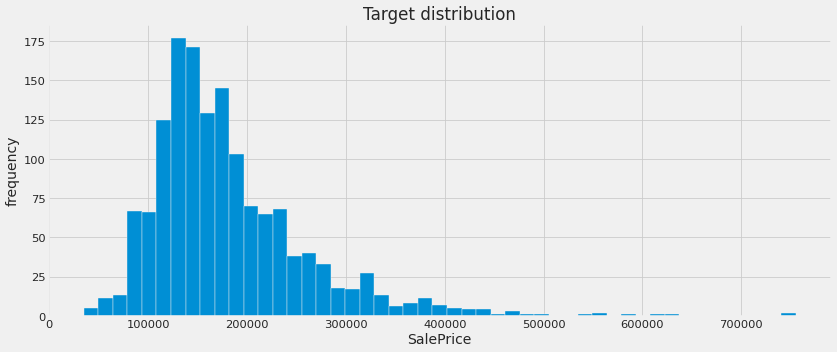

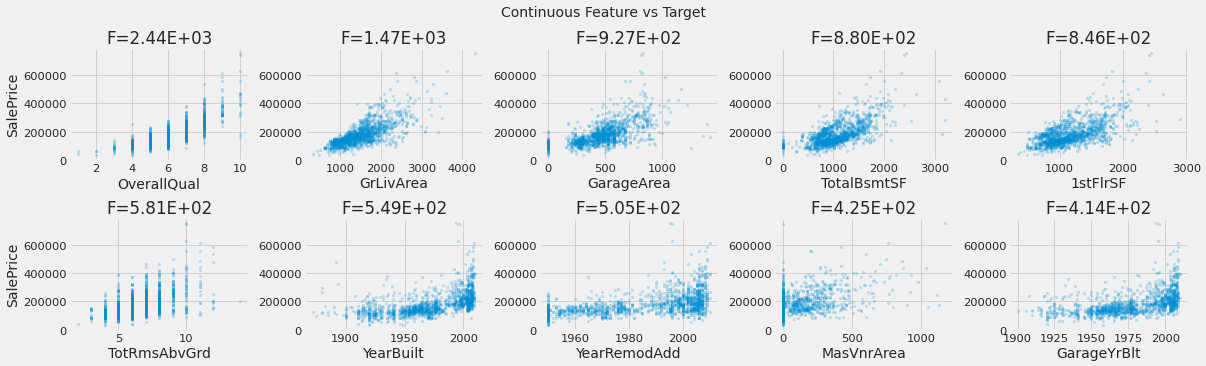

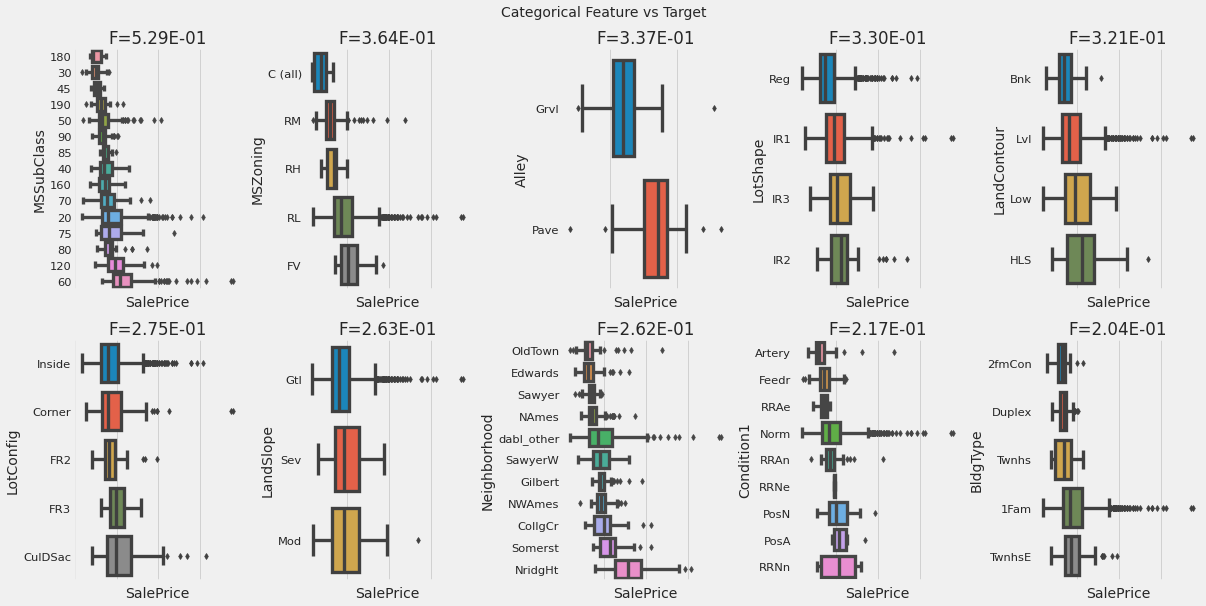

In [120]:
import dabl
dabl.plot(train, target_col = 'SalePrice')

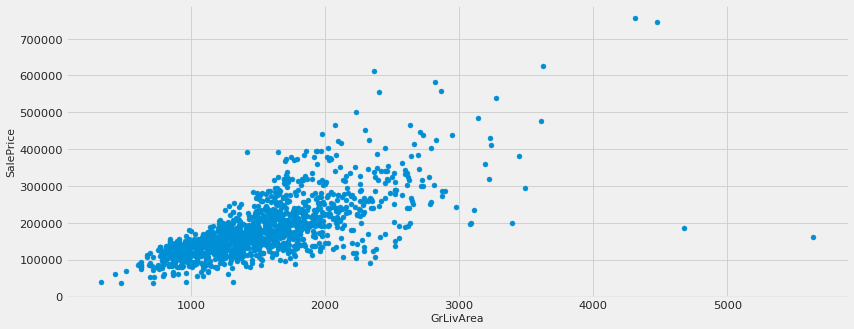

In [121]:
plot_scatter(train, 'GrLivArea', 'SalePrice')

Dropping outliers of extreme high ground living area but low sale price

In [122]:
## Delete outliers
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)

Correlation of features

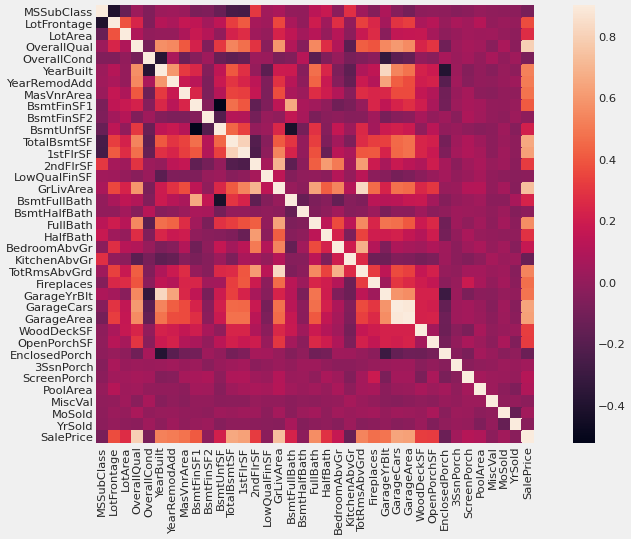

In [123]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

Top 10 important features correlated with SalePrice

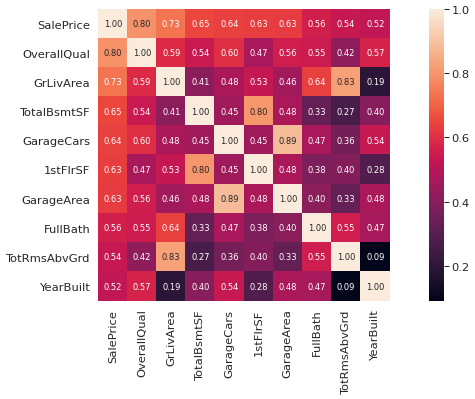

In [124]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Pairs plot of important features

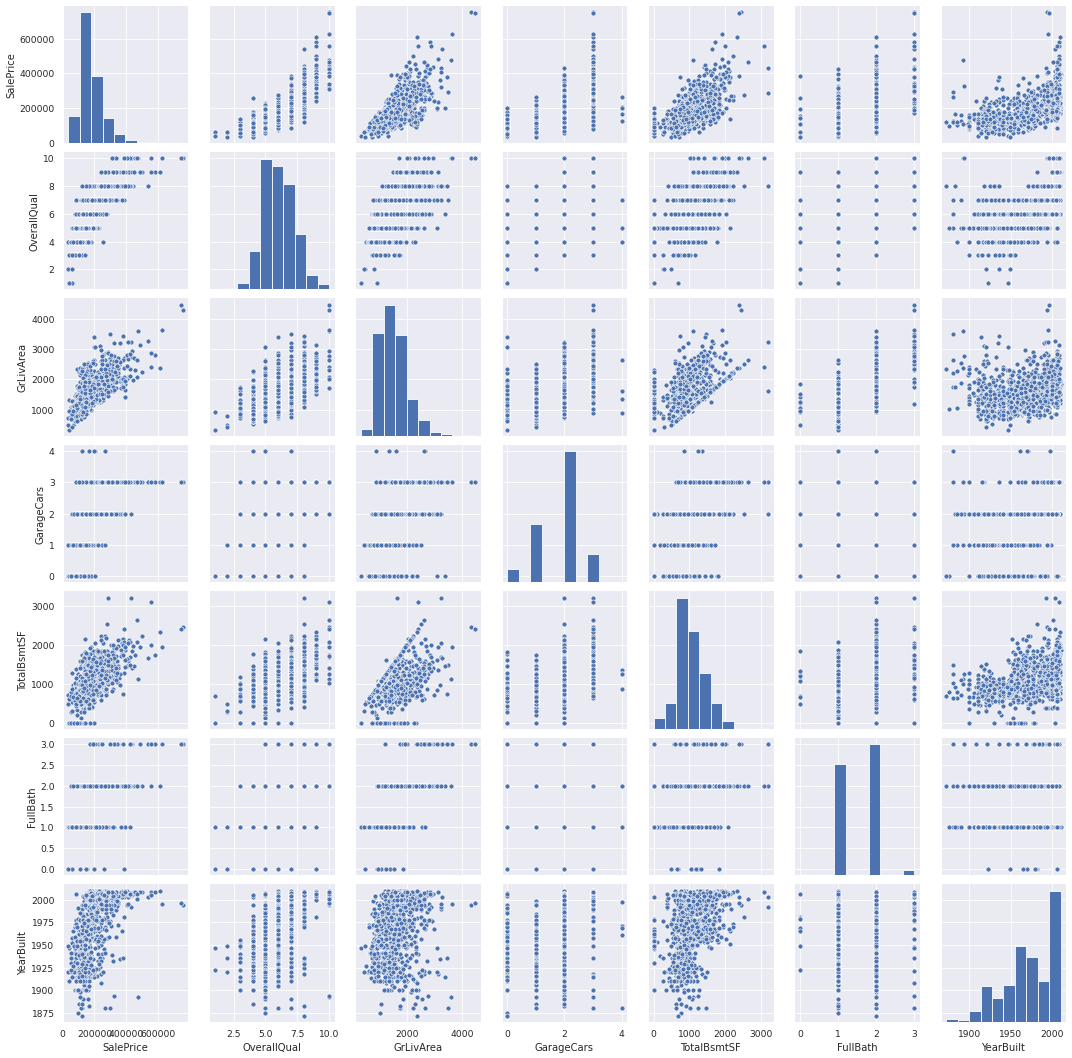

In [125]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
plot_pairs(train, cols)

---
## Data Analysis and Feature Engineering

Combining the train and test set together so that data transformation will be consistent and applied to both datasets.

It is important to note that any updates to the test set should be based on analysis or data available only in the train set.  Example, when updating column with null value in test set with the mean value observed, the mean value should be calculated based on data in the train set only and not the combined set.

However, for simplicity, all data manipulation and feature engineering done in a combined manner, assuming data in both the train and test set are consistent and similar.

In [126]:
traintest = combineTrainTest(train, test, features)
traintest.MSSubClass = traintest.MSSubClass.astype('category')
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2917 non-null category
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 

Check columns with null values

In [127]:
na_cols = traintest.columns[traintest.isna().any()].tolist()
traintest[na_cols].isnull().sum().sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

### Fixing the missing values
#### PoolQC

In [128]:
traintest.loc[(traintest.PoolQC.isnull()) & (traintest.PoolArea == 0), 'PoolQC'] = 'NA'
traintest['PoolQC'] = traintest.groupby(['OverallQual'])['PoolQC'].transform(lambda x: x.fillna(x.mode()[0]))

#### FireplaceQu

In [129]:
traintest.loc[(traintest.FireplaceQu.isnull()) & (traintest.Fireplaces == 0), 'FireplaceQu'] = 'NA'
traintest['FireplaceQu'] = traintest.groupby(['OverallQual'])['FireplaceQu'].transform(lambda x: x.fillna(x.mode()[0]))

#### MiscFeature

In [130]:
traintest.loc[(traintest.MiscFeature.isnull()), 'MiscFeature'] = 'NA'
traintest.loc[(traintest.Fence.isnull()), 'Fence'] = 'NA'
traintest.loc[(traintest.Alley.isnull()), 'Alley'] = 'NA'

#### Lot Info

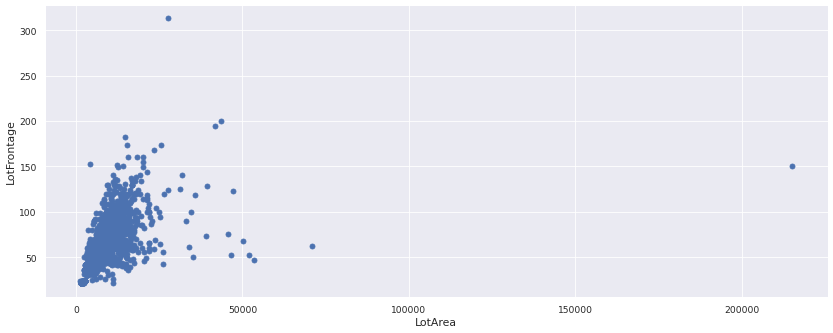

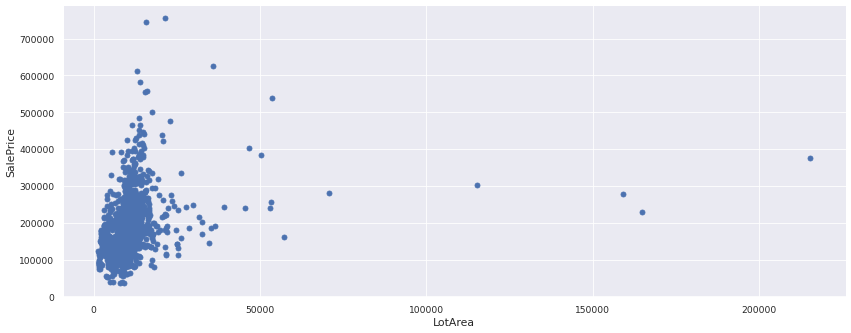

In [131]:
traintest.filter(regex='Lot').head()
plot_scatter(traintest, 'LotArea', 'LotFrontage')
plot_scatter(train, 'LotArea', 'SalePrice')

Notice the outlier.  Extremely large plot of land with with small frontage.  Winsorize the lotarea??

In [132]:
from scipy.stats.mstats import winsorize

# Check minimum sum of donations
# print(traintest["LotArea"].min())
# print(traintest["LotArea"].max())

traintest["LotArea"] = winsorize(traintest["LotArea"], limits=[0, 0.005])

In [133]:
traintest[(traintest.LotArea > 50000)].filter(regex='Lot').head()

,LotFrontage,LotArea,LotShape,LotConfig
Id,,,,


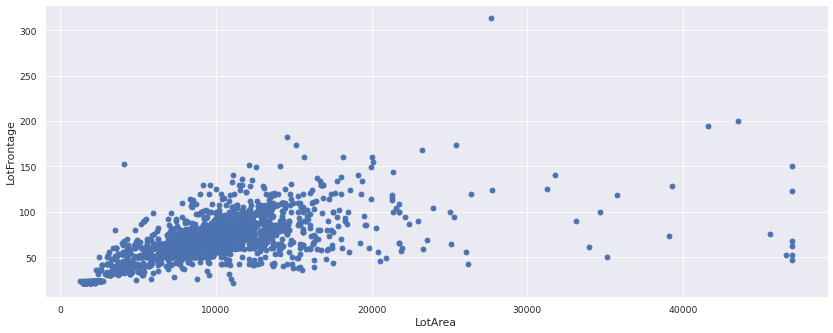

In [134]:
plot_scatter(traintest, 'LotArea', 'LotFrontage')

Create categorial features to group the lot area and then filling the missing lot frontage with respective median.

In [135]:
traintest['LotAreaGroup'] = pd.qcut(traintest['LotArea'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup','LotShape'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#### Garage Info

In [136]:
traintest.loc[(traintest.GarageYrBlt.isnull()), 'GarageYrBlt'] = -1
traintest.loc[(traintest.GarageFinish.isnull()), 'GarageFinish'] = 'NA'
traintest.loc[(traintest.GarageQual.isnull()), 'GarageQual'] = 'NA'
traintest.loc[(traintest.GarageCond.isnull()), 'GarageCond'] = 'NA'
traintest.loc[(traintest.GarageType.isnull()), 'GarageType'] = 'NA'

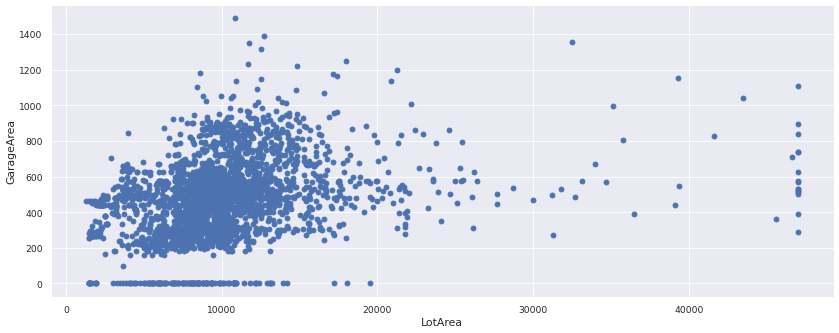

In [137]:
plot_scatter(traintest, 'LotArea', 'GarageArea')

In [138]:
traintest['GarageArea'] = traintest.groupby(['LotAreaGroup'])['GarageArea'].transform(lambda x: x.fillna(x.median()))
traintest['GarageCars'] = traintest.groupby(['LotAreaGroup'])['GarageCars'].transform(lambda x: x.fillna(x.median()))

#### Basement Info

In [139]:
traintest.loc[(traintest.BsmtCond.isnull()), 'BsmtCond'] = 'NA'
traintest.loc[(traintest.BsmtExposure.isnull()), 'BsmtExposure'] = 'NA'
traintest.loc[(traintest.BsmtQual.isnull()), 'BsmtQual'] = 'NA'
traintest.loc[(traintest.BsmtFinType1.isnull()), 'BsmtFinType1'] = 'NA'
traintest.loc[(traintest.BsmtFinType2.isnull()), 'BsmtFinType2'] = 'NA'

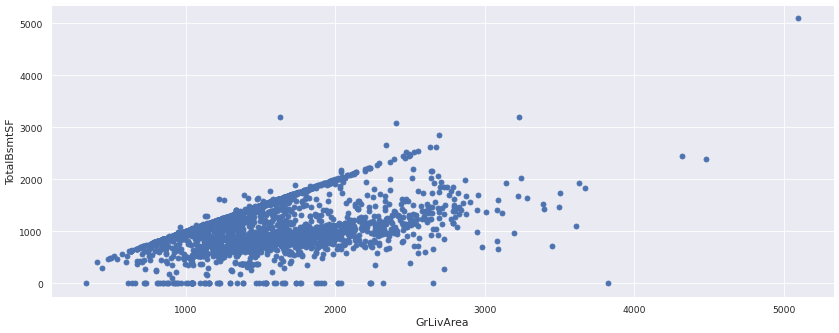

In [140]:
plot_scatter(traintest, 'GrLivArea', 'TotalBsmtSF')

In [141]:
traintest['GrLivAreaGroup'] = pd.qcut(traintest['GrLivArea'], 5, 
                                    labels=['XS','S','M','L','XL'])
traintest['TotalBsmtSF'] = traintest.groupby(['GrLivAreaGroup'])['TotalBsmtSF'].transform(lambda x: x.fillna(x.median()))

In [142]:
traintest['TotalBsmtSFGroup'] = pd.qcut(traintest['TotalBsmtSF'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['BsmtFullBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtFullBath'].transform(lambda x: x.fillna(x.median()))
traintest['BsmtHalfBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtHalfBath'].transform(lambda x: x.fillna(x.median()))


In [143]:
traintest[traintest.BsmtFinSF1.isnull()].filter(regex='Bsmt')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,TotalBsmtSFGroup
Id,,,,,,,,,,,,
2121,NA,NA,NA,NA,NaN,NA,NaN,NaN,864.0,0.0,0.0,S


This record belongs to the test data set.  Hence cannot be dropped.  Decided to drop the columns instead.

In [144]:
# traintest.loc[traintest.BsmtFinSF1.isnull(), ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
traintest = traintest.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], axis=1)

In [145]:
# garage = traintest.columns[traintest.columns.str.startswith('Garage')].tolist()
# basement = traintest.columns[traintest.columns.str.contains('Bsmt')].tolist()
# quality = traintest.columns[traintest.columns.str.contains('Qual')].tolist()

In [146]:
# na_cols = traintest.columns[traintest.isna().any()].tolist()
# traintest[na_cols].isnull().sum().sort_values(ascending=False)

#### MasVnrType Info

In [147]:
traintest.loc[(traintest.MasVnrType.isnull()) & (traintest.MasVnrArea.isnull()), 'MasVnrType'] = 'None'
traintest.loc[(traintest.MasVnrType == 'None') & (traintest.MasVnrArea.isnull()), 'MasVnrArea'] = 0
traintest['MasVnrType'] = traintest.groupby(['MSSubClass'])['MasVnrType'].transform(lambda x: x.fillna(x.mode()[0]))

#### Utilities Info

In [148]:
# traintest['Utilities'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Utilities'].transform(lambda x: x.fillna(x.mode()[0]))
train.Utilities.value_counts()
traintest = traintest.drop(['Utilities'], axis=1)

#### Miscellaneous Info

In [149]:
traintest['MSZoning'] = traintest.groupby(['MSSubClass','Neighborhood'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Functional'] = traintest.groupby(['OverallQual'])['Functional'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['KitchenQual'] = traintest.groupby('OverallQual')['KitchenQual'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Electrical'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['SaleType'] = traintest['SaleType'].fillna(traintest['SaleType'].mode()[0])


### Adding potentially useful columns
1. Total Square Feet

In [150]:
traintest['TotalSF'] = traintest['1stFlrSF'] + traintest['2ndFlrSF'] + traintest['TotalBsmtSF']

tosquare = ['LotFrontage', 'LotArea','MasVnrArea','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
               'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
               '3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF']

def genSquareColumns(data, columns):
    for column in columns:
        new_column = column + '_squared'
        data[new_column] = data[column] * data[column]
    return data
    
traintest = genSquareColumns(traintest, tosquare)

### Dropping potentially irrelevant columns

These are categorical columns with many categories.  To drop for now so that the size of the data sets for training and test are manageable.

In [151]:
todrop = ['Neighborhood','Exterior1st','Exterior2nd']
traintest = traintest.drop(todrop, axis=1)

### Final Check

Are there any columns with missing data?

In [152]:
traintest.isnull().any().any()

False

In [153]:
traintest.describe(include=np.number)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalSF,LotFrontage_squared,LotArea_squared,MasVnrArea_squared,TotalBsmtSF_squared,1stFlrSF_squared,2ndFlrSF_squared,LowQualFinSF_squared,GrLivArea_squared,GarageArea_squared,WoodDeckSF_squared,OpenPorchSF_squared,EnclosedPorch_squared,3SsnPorch_squared,ScreenPorch_squared,PoolArea_squared,MiscVal_squared,TotalSF_squared
count,2917.00000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2917.000000,2.917000e+03,2917.000000,2917.000000,2917.000000,2.917000e+03,2.917000e+03
mean,69.73843,9954.323620,6.086390,5.564964,1971.287967,1984.248200,100.931436,1049.263970,1157.692492,335.861502,4.697635,1498.251628,0.428865,0.061364,1.567364,0.379842,2.860130,1.044566,6.448063,0.596160,1870.215632,1.766198,472.409325,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938,2542.817964,5327.476517,1.256771e+08,4.187186e+04,1.284972e+06,1.488630e+06,2.960266e+05,2.175456e+03,2.491591e+06,2.692011e+05,2.477149e+04,6738.817278,4.662636e+03,641.437779,3415.941035,1198.441892,3.246407e+05,7.075068e+06
std,21.54500,5157.292522,1.406704,1.113414,30.286991,20.892257,178.032499,429.046043,385.264298,428.119663,46.412570,496.908626,0.523943,0.245687,0.552465,0.502782,0.822967,0.214532,1.564281,0.644773,450.052870,0.761412,214.584074,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328,780.610936,3745.613600,2.035648e+08,1.369339e+05,1.108392e+06,1.133223e+06,4.757984e+05,2.901128e+04,1.809437e+06,2.264124e+05,6.480499e+04,21181.165217,2.497471e+04,7922.917321,15654.371992,21785.683756,7.707883e+06,4.789417e+06
min,21.00000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,334.000000,441.000000,1.690000e+06,0.000000e+00,0.000000e+00,1.115560e+05,0.000000e+00,0.000000e+00,1.115560e+05,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.115560e+05
25%,60.00000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,2000.000000,3600.000000,5.589058e+07,0.000000e+00,6.288490e+05,7.673760e+05,0.000000e+00,0.000000e+00,1.267876e+06,1.024000e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,4.000000e+06
50%,70.00000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,988.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,2448.000000,4900.000000,8.934030e+07,0.000000e+00,9.761440e+05,1.170724e+06,0.000000e+00,0.000000e+00,2.085136e+06,2.304000e+05,0.000000e+00,676.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,5.992704e+06
75%,82.00000,

In [154]:
traintest.describe(include=[np.object])

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917
unique,5,2,3,4,4,5,3,9,8,5,8,6,7,4,4,5,6,5,5,5,7,7,6,5,2,5,4,7,6,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,NA,Reg,Lvl,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NA,Attchd,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
freq,2264,2905,2719,1859,2622,2132,2776,2511,2888,2423,1471,2310,2875,1766,1798,2536,1306,1283,2604,1904,851,2491,2872,1491,2721,2670,1493,2716,1420,1722,1230,2602,2652,2639,2908,2346,2812,2526,2402


## Preprocessing data for training
1. Splitting the combined dataset back to train and test set
2. One Hot Encoding for Categorical features
3. Normalising the Numerical features

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [156]:
def processStdScalar(train, test, columns):
    
    train_scaled = train.copy()
    test_scaled = test.copy()
    
    for column in columns:
        scalar = StandardScaler()
        scalar.fit(train[[column]])
        train_scaled[column] = scalar.transform(train[[column]])
        test_scaled[column] = scalar.transform(test[[column]])
        
    return train_scaled, test_scaled

In [157]:
traintest.shape

(2917, 93)

### One-Hot Encoding

For simplicity, using Pandas get_dummies for OHE for now.  Also applying to the combined dataset so that the encoding can be consistently applied to both train and test dataset.

In [158]:
traintest = pd.get_dummies(traintest, drop_first=True)

### Splitting the combined data set back to train and test

In [159]:
Xy, X_test = splitTrainTest(traintest, train, test, target)

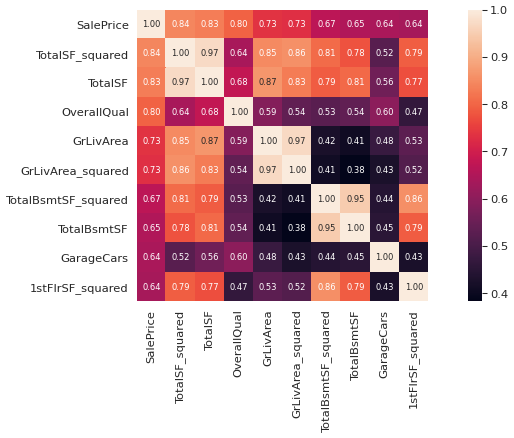

In [160]:
newcorrmat = Xy.corr()

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = newcorrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(Xy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [161]:
X = Xy.drop(target, axis=1)
y = Xy[target]

### Normalise Numerical Features
Identify numerical features to normalise

In [162]:
tonormalise = ['LotFrontage', 'LotArea','MasVnrArea','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
               'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
               '3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF']

tonormalise = tonormalise + [col+'_squared' for col in tonormalise]
# plot_pairs(Xy, tonormalise)

Normalisation was done by fitting the scaler with training data and then transforming the train and test data respectively.

In [163]:
X, X_test, = processStdScalar(X, X_test, tonormalise)

### Normalise Target Features

In [164]:
targetScalar = StandardScaler()
targetScalar.fit(y)
y.SalePrice = targetScalar.transform(y)

### Train Test (Valid) Split
Splitting the training dataset into training and validation data set.  Purpose of the validation data set is for model evaluation later.

In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=SEED)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(874, 245)
(874, 1)
(584, 245)
(584, 1)
(1459, 245)


---
## Tensorflow

In [169]:
# !pip install tensorflow
# !pip install -q git+https://github.com/tensorflow/docs

### Helper functions
1. **plot_results** - Plot training and validation data over the various epochs

In [170]:
def plot_results(data, val_data, limit=1, title='Results'):
    plt.figure()
    plt.plot(data)
    plt.plot(val_data)
    plt.ylim([0, limit])
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

In [171]:
INPUTS = len(X_train.columns)
TRAINING_OBSERVATIONS = X_train.shape[0]
print('Number of inputs to neural network: {}'.format(INPUTS))
print('Number of training observations: {}'.format(TRAINING_OBSERVATIONS))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

Number of inputs to neural network: 245
Number of training observations: 874


### Model Building Considerations:
1. Problem Identification 
    - Binary, Multiclass, Multilabel, Regression
2. Number of Dense layers
    - What is the Activation function
    - Number of Nodes in each layer
    - Any kernel_initializer?
3. Optimization function
    - learning rate and many other parameters (to explore)
4. Loss function
5. Metrics
6. Fitting Parameters
    - Optimal Batch Size
    - Training and Validation Dataset
    - Number of EPOCHS
    - EarlyStopping - patience number
    - ModelCheckpoint

Additional Considerations:
1. Normalisation layers
2. Dropout layers


In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(nodes=(16,32,16), activation='relu', learning_rate=0.002, input_dropout=0.05):
    model = Sequential()

    model.add(Dense(nodes[0], input_shape=(INPUTS,), activation='relu', kernel_initializer='normal'))
    model.add(tf.keras.layers.Dropout(input_dropout))
    
    for node in nodes[1:]:
        model.add(Dense(node, activation='relu', kernel_initializer='normal'))

    # model.add(Dense(nodes[1], activation='relu', kernel_initializer='normal'))
    # model.add(tf.keras.layers.BatchNormalization())

    model.add(Dense(1))

    # optimizer = tf.keras.optimizers.RMSprop(0.03)
    # opt = 'RMSprop'
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

    return model

### Hyperparameters Search

In [188]:
import itertools

layer1 = [16,32,64]
layer2 = [16,32,64]
layer3 = [16,32,64]
layers = [layer1, layer2, layer3]

NODES_LIST = list(itertools.product(*layers))
ACTIVATION_LIST = ['relu']
BATCHSIZE_LIST = [874]
EPOCHS_LIST = [2000]
LEARNINGRATE_LIST = [0.0005]
INPUTDROPOUT_LIST = [0.05]

# Import KerasRegressor from keras wrappers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Create a KerasRegressor
grid_buildmodel = KerasRegressor(build_fn = build_model)

# Define the parameters to try out
params = {'nodes': NODES_LIST, 
          'activation': ACTIVATION_LIST, 
          'batch_size': BATCHSIZE_LIST, 
          'epochs': EPOCHS_LIST, 
          'input_dropout': INPUTDROPOUT_LIST, 
          'learning_rate': LEARNINGRATE_LIST}

print(params)

{'nodes': [(16, 16, 16), (16, 16, 32), (16, 16, 64), (16, 32, 16), (16, 32, 32), (16, 32, 64), (16, 64, 16), (16, 64, 32), (16, 64, 64), (32, 16, 16), (32, 16, 32), (32, 16, 64), (32, 32, 16), (32, 32, 32), (32, 32, 64), (32, 64, 16), (32, 64, 32), (32, 64, 64), (64, 16, 16), (64, 16, 32), (64, 16, 64), (64, 32, 16), (64, 32, 32), (64, 32, 64), (64, 64, 16), (64, 64, 32), (64, 64, 64)], 'activation': ['relu'], 'batch_size': [874], 'epochs': [2000], 'input_dropout': [0.05], 'learning_rate': [0.0005]}


In [177]:
grid_search = GridSearchCV(grid_buildmodel, param_grid = params, cv = 3, verbose=0, return_train_score=True)

%time grid_search.fit(X_train, y_train)

Epoch 1/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.7877 - mae: 1.3813 - mse: 2.7877
Epoch 2/2000
1/1 [==============================] - 0s 953us/step - loss: 1.7474 - mae: 0.9468 - mse: 1.7474
Epoch 3/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.1321 - mae: 1.0747 - mse: 2.1321
Epoch 4/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.7669 - mae: 0.9264 - mse: 1.7669
Epoch 5/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.4071 - mae: 0.8563 - mse: 1.4071
Epoch 6/2000
1/1 [==============================] - 0s 19ms/step - loss: 1.3861 - mae: 0.9238 - mse: 1.3861
Epoch 7/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.5310 - mae: 0.9954 - mse: 1.5310
Epoch 8/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.5447 - mae: 0.9709 - mse: 1.5447
Epoch 9/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2220 - mae: 0.8470 - mse: 1.2220
Epoch 10/2000
1/1 [===============

1/1 [==============================] - 0s 1ms/step - loss: 0.8978 - mae: 0.6773 - mse: 0.8978
Epoch 77/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8751 - mae: 0.6632 - mse: 0.8751
Epoch 78/2000
1/1 [==============================] - 0s 925us/step - loss: 0.8802 - mae: 0.6693 - mse: 0.8802
Epoch 79/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8809 - mae: 0.6659 - mse: 0.8809
Epoch 80/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8746 - mae: 0.6645 - mse: 0.8746
Epoch 81/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8713 - mae: 0.6614 - mse: 0.8713
Epoch 82/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8590 - mae: 0.6553 - mse: 0.8590
Epoch 83/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.8903 - mae: 0.6754 - mse: 0.8903
Epoch 84/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8560 - mae: 0.6623 - mse: 0.8560
Epoch 85/2000
1/1 [====================

Epoch 151/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5585 - mae: 0.5052 - mse: 0.5585
Epoch 152/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5555 - mae: 0.4983 - mse: 0.5555
Epoch 153/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5486 - mae: 0.4992 - mse: 0.5486
Epoch 154/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5702 - mae: 0.4998 - mse: 0.5702
Epoch 155/2000
1/1 [==============================] - 0s 931us/step - loss: 0.5221 - mae: 0.4622 - mse: 0.5221
Epoch 156/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5500 - mae: 0.5015 - mse: 0.5500
Epoch 157/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5313 - mae: 0.4586 - mse: 0.5313
Epoch 158/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5339 - mae: 0.5049 - mse: 0.5339
Epoch 159/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.5047 - mae: 0.4506 - mse: 0.5047
Epoch 160/2000
1

1/1 [==============================] - 0s 1ms/step - loss: 0.2882 - mae: 0.3236 - mse: 0.2882
Epoch 226/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2806 - mae: 0.3182 - mse: 0.2806
Epoch 227/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3141 - mae: 0.3410 - mse: 0.3141
Epoch 228/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3005 - mae: 0.3315 - mse: 0.3005
Epoch 229/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2918 - mae: 0.3323 - mse: 0.2918
Epoch 230/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.3007 - mae: 0.3414 - mse: 0.3007
Epoch 231/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2941 - mae: 0.3334 - mse: 0.2941
Epoch 232/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2942 - mae: 0.3395 - mse: 0.2942
Epoch 233/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3304 - mae: 0.3534 - mse: 0.3304
Epoch 234/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2248 - mae: 0.2855 - mse: 0.2248
Epoch 300/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2673 - mae: 0.3059 - mse: 0.2673
Epoch 301/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2502 - mae: 0.3030 - mse: 0.2502
Epoch 302/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2447 - mae: 0.2945 - mse: 0.2447
Epoch 303/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2570 - mae: 0.2933 - mse: 0.2570
Epoch 304/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2539 - mae: 0.3141 - mse: 0.2539
Epoch 305/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2354 - mae: 0.3019 - mse: 0.2354
Epoch 306/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2334 - mae: 0.2911 - mse: 0.2334
Epoch 307/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2161 - mae: 0.2879 - mse: 0.2161
Epoch 308/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2010 - mae: 0.2727 - mse: 0.2010
Epoch 373/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2020 - mae: 0.2673 - mse: 0.2020
Epoch 374/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1872 - mae: 0.2775 - mse: 0.1872
Epoch 375/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.2042 - mae: 0.2909 - mse: 0.2042
Epoch 376/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1941 - mae: 0.2690 - mse: 0.1941
Epoch 377/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1968 - mae: 0.2736 - mse: 0.1968
Epoch 378/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1912 - mae: 0.2799 - mse: 0.1912
Epoch 379/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2032 - mae: 0.2816 - mse: 0.2032
Epoch 380/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1882 - mae: 0.2748 - mse: 0.1882
Epoch 381/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1546 - mae: 0.2632 - mse: 0.1546
Epoch 447/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1701 - mae: 0.2680 - mse: 0.1701
Epoch 448/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1631 - mae: 0.2581 - mse: 0.1631
Epoch 449/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1411 - mae: 0.2445 - mse: 0.1411
Epoch 450/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1711 - mae: 0.2637 - mse: 0.1711
Epoch 451/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1876 - mae: 0.2913 - mse: 0.1876
Epoch 452/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1716 - mae: 0.2669 - mse: 0.1716
Epoch 453/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1473 - mae: 0.2609 - mse: 0.1473
Epoch 454/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1785 - mae: 0.2559 - mse: 0.1785
Epoch 455/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1526 - mae: 0.2816 - mse: 0.1526
Epoch 522/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1483 - mae: 0.2635 - mse: 0.1483
Epoch 523/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1372 - mae: 0.2538 - mse: 0.1372
Epoch 524/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1259 - mae: 0.2312 - mse: 0.1259
Epoch 525/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1378 - mae: 0.2455 - mse: 0.1378
Epoch 526/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1405 - mae: 0.2687 - mse: 0.1405
Epoch 527/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1422 - mae: 0.2472 - mse: 0.1422
Epoch 528/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1287 - mae: 0.2453 - mse: 0.1287
Epoch 529/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1387 - mae: 0.2657 - mse: 0.1387
Epoch 530/2000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 0.1318 - mae: 0.2504 - mse: 0.1318
Epoch 596/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1520 - mae: 0.2511 - mse: 0.1520
Epoch 597/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1309 - mae: 0.2341 - mse: 0.1309
Epoch 598/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1118 - mae: 0.2347 - mse: 0.1118
Epoch 599/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1229 - mae: 0.2544 - mse: 0.1229
Epoch 600/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1085 - mae: 0.2245 - mse: 0.1085
Epoch 601/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1187 - mae: 0.2338 - mse: 0.1187
Epoch 602/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1501 - mae: 0.2567 - mse: 0.1501
Epoch 603/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1465 - mae: 0.2499 - mse: 0.1465
Epoch 604/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.1230 - mae: 0.2271 - mse: 0.1230
Epoch 670/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2130 - mse: 0.0908
Epoch 671/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.2092 - mse: 0.0986
Epoch 672/2000
1/1 [==============================] - 0s 37ms/step - loss: 0.1162 - mae: 0.2156 - mse: 0.1162
Epoch 673/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1217 - mae: 0.2176 - mse: 0.1217
Epoch 674/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0987 - mae: 0.2158 - mse: 0.0987
Epoch 675/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1234 - mae: 0.2175 - mse: 0.1234
Epoch 676/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1024 - mae: 0.2158 - mse: 0.1024
Epoch 677/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - mae: 0.2185 - mse: 0.1019
Epoch 678/2000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0981 - mae: 0.2097 - mse: 0.0981
Epoch 743/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1037 - mae: 0.2125 - mse: 0.1037
Epoch 744/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0931 - mae: 0.2216 - mse: 0.0931
Epoch 745/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1144 - mae: 0.2263 - mse: 0.1144
Epoch 746/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0965 - mae: 0.2309 - mse: 0.0965
Epoch 747/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mae: 0.2208 - mse: 0.1017
Epoch 748/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0919 - mae: 0.2081 - mse: 0.0919
Epoch 749/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2045 - mse: 0.0839
Epoch 750/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1145 - mae: 0.2156 - mse: 0.1145
Epoch 751/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0828 - mae: 0.1962 - mse: 0.0828
Epoch 817/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0803 - mae: 0.1984 - mse: 0.0803
Epoch 818/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1959 - mse: 0.0744
Epoch 819/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0836 - mae: 0.2017 - mse: 0.0836
Epoch 820/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0755 - mae: 0.1965 - mse: 0.0755
Epoch 821/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0876 - mae: 0.2160 - mse: 0.0876
Epoch 822/2000
1/1 [==============================] - 0s 888us/step - loss: 0.0874 - mae: 0.2058 - mse: 0.0874
Epoch 823/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2040 - mse: 0.0839
Epoch 824/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0833 - mae: 0.2008 - mse: 0.0833
Epoch 825/2000
1/1 [============

1/1 [==============================] - 0s 4ms/step - loss: 0.0839 - mae: 0.2030 - mse: 0.0839
Epoch 890/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0908 - mae: 0.2234 - mse: 0.0908
Epoch 891/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0783 - mae: 0.1892 - mse: 0.0783
Epoch 892/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0736 - mae: 0.1934 - mse: 0.0736
Epoch 893/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0903 - mae: 0.2198 - mse: 0.0903
Epoch 894/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0799 - mae: 0.2004 - mse: 0.0799
Epoch 895/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0758 - mae: 0.1943 - mse: 0.0758
Epoch 896/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1009 - mae: 0.2086 - mse: 0.1009
Epoch 897/2000
1/1 [==============================] - 0s 886us/step - loss: 0.0856 - mae: 0.2064 - mse: 0.0856
Epoch 898/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0702 - mae: 0.1887 - mse: 0.0702
Epoch 965/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0674 - mae: 0.1878 - mse: 0.0674
Epoch 966/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0739 - mae: 0.1986 - mse: 0.0739
Epoch 967/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0744 - mae: 0.1990 - mse: 0.0744
Epoch 968/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0825 - mae: 0.2037 - mse: 0.0825
Epoch 969/2000
1/1 [==============================] - 0s 39ms/step - loss: 0.0712 - mae: 0.1901 - mse: 0.0712
Epoch 970/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0673 - mae: 0.1815 - mse: 0.0673
Epoch 971/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0698 - mae: 0.1885 - mse: 0.0698
Epoch 972/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0729 - mae: 0.1906 - mse: 0.0729
Epoch 973/2000
1/1 [=============

1/1 [==============================] - 0s 994us/step - loss: 0.0789 - mae: 0.2081 - mse: 0.0789
Epoch 1039/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0739 - mae: 0.2029 - mse: 0.0739
Epoch 1040/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0803 - mae: 0.2036 - mse: 0.0803
Epoch 1041/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mae: 0.2197 - mse: 0.1021
Epoch 1042/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0785 - mae: 0.2121 - mse: 0.0785
Epoch 1043/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0763 - mae: 0.1909 - mse: 0.0763
Epoch 1044/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1945 - mse: 0.0703
Epoch 1045/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0857 - mae: 0.2200 - mse: 0.0857
Epoch 1046/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0752 - mae: 0.1999 - mse: 0.0752
Epoch 1047/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0689 - mae: 0.1841 - mse: 0.0689
Epoch 1113/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0820 - mae: 0.2020 - mse: 0.0820
Epoch 1114/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0776 - mae: 0.1961 - mse: 0.0776
Epoch 1115/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1881 - mse: 0.0669
Epoch 1116/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1795 - mse: 0.0623
Epoch 1117/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0796 - mae: 0.2044 - mse: 0.0796
Epoch 1118/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0677 - mae: 0.1869 - mse: 0.0677
Epoch 1119/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0658 - mae: 0.1854 - mse: 0.0658
Epoch 1120/2000
1/1 [==============================] - 0s 840us/step - loss: 0.0716 - mae: 0.1920 - mse: 0.0716
Epoch 1121/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0636 - mae: 0.1818 - mse: 0.0636
Epoch 1187/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0762 - mae: 0.1930 - mse: 0.0762
Epoch 1188/2000
1/1 [==============================] - 0s 984us/step - loss: 0.0716 - mae: 0.1950 - mse: 0.0716
Epoch 1189/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0672 - mae: 0.1852 - mse: 0.0672
Epoch 1190/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0864 - mae: 0.1813 - mse: 0.0864
Epoch 1191/2000
1/1 [==============================] - 0s 884us/step - loss: 0.0671 - mae: 0.1864 - mse: 0.0671
Epoch 1192/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0675 - mae: 0.1866 - mse: 0.0675
Epoch 1193/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0728 - mae: 0.1856 - mse: 0.0728
Epoch 1194/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1887 - mse: 0.0693
Epoch 1195/2000
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.0719 - mae: 0.1848 - mse: 0.0719
Epoch 1261/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0596 - mae: 0.1778 - mse: 0.0596
Epoch 1262/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1831 - mse: 0.0686
Epoch 1263/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1797 - mse: 0.0595
Epoch 1264/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0616 - mae: 0.1821 - mse: 0.0616
Epoch 1265/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0602 - mae: 0.1802 - mse: 0.0602
Epoch 1266/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1765 - mse: 0.0593
Epoch 1267/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0636 - mae: 0.1831 - mse: 0.0636
Epoch 1268/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1850 - mse: 0.0695
Epoch 1269/2000
1/1 [=====

1/1 [==============================] - 0s 927us/step - loss: 0.0868 - mae: 0.2065 - mse: 0.0868
Epoch 1334/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0677 - mae: 0.1867 - mse: 0.0677
Epoch 1335/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0582 - mae: 0.1802 - mse: 0.0582
Epoch 1336/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0778 - mae: 0.1982 - mse: 0.0778
Epoch 1337/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0620 - mae: 0.1846 - mse: 0.0620
Epoch 1338/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.1747 - mse: 0.0613
Epoch 1339/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0764 - mae: 0.1909 - mse: 0.0764
Epoch 1340/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1935 - mse: 0.0647
Epoch 1341/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0569 - mae: 0.1725 - mse: 0.0569
Epoch 1342/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0770 - mae: 0.2093 - mse: 0.0770
Epoch 1408/2000
1/1 [==============================] - 0s 922us/step - loss: 0.0708 - mae: 0.1944 - mse: 0.0708
Epoch 1409/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0602 - mae: 0.1789 - mse: 0.0602
Epoch 1410/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0571 - mae: 0.1739 - mse: 0.0571
Epoch 1411/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0682 - mae: 0.1951 - mse: 0.0682
Epoch 1412/2000
1/1 [==============================] - 0s 940us/step - loss: 0.0706 - mae: 0.2047 - mse: 0.0706
Epoch 1413/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0798 - mae: 0.2019 - mse: 0.0798
Epoch 1414/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0837 - mae: 0.1881 - mse: 0.0837
Epoch 1415/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1729 - mse: 0.0647
Epoch 1416/2000
1/1 [=

1/1 [==============================] - 0s 871us/step - loss: 0.0556 - mae: 0.1735 - mse: 0.0556
Epoch 1481/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0594 - mae: 0.1836 - mse: 0.0594
Epoch 1482/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0660 - mae: 0.1845 - mse: 0.0660
Epoch 1483/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0510 - mae: 0.1671 - mse: 0.0510
Epoch 1484/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0606 - mae: 0.1770 - mse: 0.0606
Epoch 1485/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.1794 - mse: 0.0634
Epoch 1486/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0580 - mae: 0.1791 - mse: 0.0580
Epoch 1487/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0498 - mae: 0.1633 - mse: 0.0498
Epoch 1488/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0591 - mae: 0.1755 - mse: 0.0591
Epoch 1489/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1711 - mse: 0.0554
Epoch 1555/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0551 - mae: 0.1659 - mse: 0.0551
Epoch 1556/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0750 - mae: 0.1699 - mse: 0.0750
Epoch 1557/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.1758 - mse: 0.0757
Epoch 1558/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0551 - mae: 0.1725 - mse: 0.0551
Epoch 1559/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0815 - mae: 0.1697 - mse: 0.0815
Epoch 1560/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0569 - mae: 0.1727 - mse: 0.0569
Epoch 1561/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0598 - mae: 0.1749 - mse: 0.0598
Epoch 1562/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0561 - mae: 0.1736 - mse: 0.0561
Epoch 1563/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mae: 0.1639 - mse: 0.0482
Epoch 1628/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0501 - mae: 0.1618 - mse: 0.0501
Epoch 1629/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.1725 - mse: 0.0603
Epoch 1630/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0503 - mae: 0.1641 - mse: 0.0503
Epoch 1631/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0521 - mae: 0.1771 - mse: 0.0521
Epoch 1632/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0766 - mae: 0.1840 - mse: 0.0766
Epoch 1633/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0508 - mae: 0.1695 - mse: 0.0508
Epoch 1634/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0504 - mae: 0.1644 - mse: 0.0504
Epoch 1635/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0614 - mae: 0.1787 - mse: 0.0614
Epoch 1636/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1878 - mse: 0.0715
Epoch 1702/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1885 - mse: 0.0650
Epoch 1703/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0652 - mae: 0.2024 - mse: 0.0652
Epoch 1704/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0568 - mae: 0.1830 - mse: 0.0568
Epoch 1705/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1733 - mse: 0.0650
Epoch 1706/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0578 - mae: 0.1687 - mse: 0.0578
Epoch 1707/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0527 - mae: 0.1725 - mse: 0.0527
Epoch 1708/2000
1/1 [==============================] - 0s 954us/step - loss: 0.0495 - mae: 0.1663 - mse: 0.0495
Epoch 1709/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0463 - mae: 0.1570 - mse: 0.0463
Epoch 1710/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0465 - mae: 0.1577 - mse: 0.0465
Epoch 1776/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0492 - mae: 0.1635 - mse: 0.0492
Epoch 1777/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0531 - mae: 0.1714 - mse: 0.0531
Epoch 1778/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1763 - mse: 0.0605
Epoch 1779/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0555 - mae: 0.1611 - mse: 0.0555
Epoch 1780/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1642 - mse: 0.0503
Epoch 1781/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0589 - mae: 0.1848 - mse: 0.0589
Epoch 1782/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1864 - mse: 0.0598
Epoch 1783/2000
1/1 [==============================] - 0s 898us/step - loss: 0.0541 - mae: 0.1711 - mse: 0.0541
Epoch 1784/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0522 - mae: 0.1663 - mse: 0.0522
Epoch 1850/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0526 - mae: 0.1727 - mse: 0.0526
Epoch 1851/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0479 - mae: 0.1599 - mse: 0.0479
Epoch 1852/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0456 - mae: 0.1575 - mse: 0.0456
Epoch 1853/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0493 - mae: 0.1718 - mse: 0.0493
Epoch 1854/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0507 - mae: 0.1673 - mse: 0.0507
Epoch 1855/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0503 - mae: 0.1611 - mse: 0.0503
Epoch 1856/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0455 - mae: 0.1561 - mse: 0.0455
Epoch 1857/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0498 - mae: 0.1659 - mse: 0.0498
Epoch 1858/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0420 - mae: 0.1518 - mse: 0.0420
Epoch 1924/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0424 - mae: 0.1547 - mse: 0.0424
Epoch 1925/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0463 - mae: 0.1557 - mse: 0.0463
Epoch 1926/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0505 - mae: 0.1562 - mse: 0.0505
Epoch 1927/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0490 - mae: 0.1620 - mse: 0.0490
Epoch 1928/2000
1/1 [==============================] - 0s 994us/step - loss: 0.0607 - mae: 0.1703 - mse: 0.0607
Epoch 1929/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mae: 0.1675 - mse: 0.0484
Epoch 1930/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0540 - mae: 0.1659 - mse: 0.0540
Epoch 1931/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0599 - mae: 0.1630 - mse: 0.0599
Epoch 1932/2000
1/1 [===

1/1 [==============================] - 0s 4ms/step - loss: 0.0441 - mae: 0.1527 - mse: 0.0441
Epoch 1998/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0447 - mae: 0.1579 - mse: 0.0447
Epoch 1999/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0436 - mae: 0.1567 - mse: 0.0436
Epoch 2000/2000
1/1 [==============================] - 0s 888us/step - loss: 0.0376 - mae: 0.1439 - mse: 0.0376
Epoch 1/2000
1/1 [==============================] - 0s 1ms/step - loss: 17.0290 - mae: 3.9959 - mse: 17.0290
Epoch 2/2000
1/1 [==============================] - 0s 1ms/step - loss: 8.9392 - mae: 2.8280 - mse: 8.9392
Epoch 3/2000
1/1 [==============================] - 0s 1ms/step - loss: 3.9438 - mae: 1.8108 - mse: 3.9438
Epoch 4/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.5846 - mae: 1.0402 - mse: 1.5846
Epoch 5/2000
1/1 [==============================] - 0s 3ms/step - loss: 1.1434 - mae: 0.7567 - mse: 1.1434
Epoch 6/2000
1/1 [===================

1/1 [==============================] - 0s 1ms/step - loss: 0.9347 - mae: 0.7198 - mse: 0.9347
Epoch 71/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9096 - mae: 0.6959 - mse: 0.9096
Epoch 72/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8944 - mae: 0.6878 - mse: 0.8944
Epoch 73/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.8906 - mae: 0.6828 - mse: 0.8906
Epoch 74/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9011 - mae: 0.6814 - mse: 0.9011
Epoch 75/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9206 - mae: 0.6876 - mse: 0.9206
Epoch 76/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9187 - mae: 0.6867 - mse: 0.9187
Epoch 77/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8911 - mae: 0.6780 - mse: 0.8911
Epoch 78/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8981 - mae: 0.6789 - mse: 0.8981
Epoch 79/2000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.8809 - mae: 0.6809 - mse: 0.8809
Epoch 146/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8728 - mae: 0.6767 - mse: 0.8728
Epoch 147/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8837 - mae: 0.6843 - mse: 0.8837
Epoch 148/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8751 - mae: 0.6802 - mse: 0.8751
Epoch 149/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.8800 - mae: 0.6791 - mse: 0.8800
Epoch 150/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.8877 - mae: 0.6847 - mse: 0.8877
Epoch 151/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8712 - mae: 0.6754 - mse: 0.8712
Epoch 152/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8854 - mae: 0.6822 - mse: 0.8854
Epoch 153/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8818 - mae: 0.6834 - mse: 0.8818
Epoch 154/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.8541 - mae: 0.6741 - mse: 0.8541
Epoch 221/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8449 - mae: 0.6657 - mse: 0.8449
Epoch 222/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8638 - mae: 0.6713 - mse: 0.8638
Epoch 223/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8412 - mae: 0.6618 - mse: 0.8412
Epoch 224/2000
1/1 [==============================] - 0s 983us/step - loss: 0.8543 - mae: 0.6705 - mse: 0.8543
Epoch 225/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8485 - mae: 0.6631 - mse: 0.8485
Epoch 226/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8472 - mae: 0.6689 - mse: 0.8472
Epoch 227/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8398 - mae: 0.6635 - mse: 0.8398
Epoch 228/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8339 - mae: 0.6606 - mse: 0.8339
Epoch 229/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.7762 - mae: 0.6394 - mse: 0.7762
Epoch 295/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7671 - mae: 0.6311 - mse: 0.7671
Epoch 296/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.7756 - mae: 0.6350 - mse: 0.7756
Epoch 297/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7935 - mae: 0.6370 - mse: 0.7935
Epoch 298/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7949 - mae: 0.6307 - mse: 0.7949
Epoch 299/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7747 - mae: 0.6296 - mse: 0.7747
Epoch 300/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.7787 - mae: 0.6345 - mse: 0.7787
Epoch 301/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7679 - mae: 0.6346 - mse: 0.7679
Epoch 302/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7507 - mae: 0.6290 - mse: 0.7507
Epoch 303/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.4397 - mae: 0.4193 - mse: 0.4397
Epoch 369/2000
1/1 [==============================] - ETA: 0s - loss: 0.4236 - mae: 0.4673 - mse: 0.423 - 0s 2ms/step - loss: 0.4236 - mae: 0.4673 - mse: 0.4236
Epoch 370/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4019 - mae: 0.4173 - mse: 0.4019
Epoch 371/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3807 - mae: 0.4047 - mse: 0.3807
Epoch 372/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4146 - mae: 0.4592 - mse: 0.4146
Epoch 373/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4023 - mae: 0.3987 - mse: 0.4023
Epoch 374/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4084 - mae: 0.4022 - mse: 0.4084
Epoch 375/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3970 - mae: 0.4499 - mse: 0.3970
Epoch 376/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4048 - mae: 0.4

1/1 [==============================] - 0s 3ms/step - loss: 0.2635 - mae: 0.3434 - mse: 0.2635
Epoch 443/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2118 - mae: 0.3017 - mse: 0.2118
Epoch 444/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2073 - mae: 0.3059 - mse: 0.2073
Epoch 445/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2384 - mae: 0.3355 - mse: 0.2384
Epoch 446/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2124 - mae: 0.3168 - mse: 0.2124
Epoch 447/2000
1/1 [==============================] - 0s 974us/step - loss: 0.2371 - mae: 0.3120 - mse: 0.2371
Epoch 448/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2307 - mae: 0.3254 - mse: 0.2307
Epoch 449/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2359 - mae: 0.3220 - mse: 0.2359
Epoch 450/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2158 - mae: 0.3093 - mse: 0.2158
Epoch 451/2000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.1653 - mae: 0.2848 - mse: 0.1653
Epoch 517/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1808 - mae: 0.2812 - mse: 0.1808
Epoch 518/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.1815 - mae: 0.2882 - mse: 0.1815
Epoch 519/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1853 - mae: 0.2833 - mse: 0.1853
Epoch 520/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1924 - mae: 0.2869 - mse: 0.1924
Epoch 521/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1625 - mae: 0.2784 - mse: 0.1625
Epoch 522/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1775 - mae: 0.2891 - mse: 0.1775
Epoch 523/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1793 - mae: 0.2961 - mse: 0.1793
Epoch 524/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1656 - mae: 0.2845 - mse: 0.1656
Epoch 525/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1435 - mae: 0.2662 - mse: 0.1435
Epoch 591/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1511 - mae: 0.2736 - mse: 0.1511
Epoch 592/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1616 - mae: 0.2797 - mse: 0.1616
Epoch 593/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1701 - mae: 0.2734 - mse: 0.1701
Epoch 594/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1442 - mae: 0.2638 - mse: 0.1442
Epoch 595/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1754 - mae: 0.2866 - mse: 0.1754
Epoch 596/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1396 - mae: 0.2591 - mse: 0.1396
Epoch 597/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1589 - mae: 0.2777 - mse: 0.1589
Epoch 598/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1635 - mae: 0.2775 - mse: 0.1635
Epoch 599/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1525 - mae: 0.2696 - mse: 0.1525
Epoch 665/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1753 - mae: 0.2832 - mse: 0.1753
Epoch 666/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1319 - mae: 0.2574 - mse: 0.1319
Epoch 667/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1533 - mae: 0.2574 - mse: 0.1533
Epoch 668/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1396 - mae: 0.2597 - mse: 0.1396
Epoch 669/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1382 - mae: 0.2728 - mse: 0.1382
Epoch 670/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1546 - mae: 0.2728 - mse: 0.1546
Epoch 671/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1409 - mae: 0.2583 - mse: 0.1409
Epoch 672/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1269 - mae: 0.2493 - mse: 0.1269
Epoch 673/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1312 - mae: 0.2503 - mse: 0.1312
Epoch 737/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1112 - mae: 0.2312 - mse: 0.1112
Epoch 738/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1173 - mae: 0.2373 - mse: 0.1173
Epoch 739/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1204 - mae: 0.2444 - mse: 0.1204
Epoch 740/2000
1/1 [==============================] - ETA: 0s - loss: 0.1550 - mae: 0.2524 - mse: 0.155 - 0s 4ms/step - loss: 0.1550 - mae: 0.2524 - mse: 0.1550
Epoch 741/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1221 - mae: 0.2329 - mse: 0.1221
Epoch 742/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1161 - mae: 0.2363 - mse: 0.1161
Epoch 743/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1131 - mae: 0.2320 - mse: 0.1131
Epoch 744/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1202 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.1088 - mae: 0.2251 - mse: 0.1088
Epoch 811/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1030 - mae: 0.2209 - mse: 0.1030
Epoch 812/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0992 - mae: 0.2265 - mse: 0.0992
Epoch 813/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1125 - mae: 0.2327 - mse: 0.1125
Epoch 814/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1283 - mae: 0.2391 - mse: 0.1283
Epoch 815/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1043 - mae: 0.2244 - mse: 0.1043
Epoch 816/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1038 - mae: 0.2227 - mse: 0.1038
Epoch 817/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1045 - mae: 0.2285 - mse: 0.1045
Epoch 818/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1179 - mae: 0.2289 - mse: 0.1179
Epoch 819/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1047 - mae: 0.2302 - mse: 0.1047
Epoch 884/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1072 - mae: 0.2285 - mse: 0.1072
Epoch 885/2000
1/1 [==============================] - ETA: 0s - loss: 0.1023 - mae: 0.2235 - mse: 0.102 - 0s 1ms/step - loss: 0.1023 - mae: 0.2235 - mse: 0.1023
Epoch 886/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0963 - mae: 0.2169 - mse: 0.0963
Epoch 887/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1007 - mae: 0.2258 - mse: 0.1007
Epoch 888/2000
1/1 [==============================] - 0s 916us/step - loss: 0.1046 - mae: 0.2248 - mse: 0.1046
Epoch 889/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1037 - mae: 0.2256 - mse: 0.1037
Epoch 890/2000
1/1 [==============================] - 0s 742us/step - loss: 0.1182 - mae: 0.2350 - mse: 0.1182
Epoch 891/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0999 - mae:

1/1 [==============================] - 0s 1ms/step - loss: 0.0928 - mae: 0.2182 - mse: 0.0928
Epoch 958/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1089 - mae: 0.2267 - mse: 0.1089
Epoch 959/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1011 - mae: 0.2216 - mse: 0.1011
Epoch 960/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0873 - mae: 0.2032 - mse: 0.0873
Epoch 961/2000
1/1 [==============================] - 0s 950us/step - loss: 0.0842 - mae: 0.2068 - mse: 0.0842
Epoch 962/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0991 - mae: 0.2205 - mse: 0.0991
Epoch 963/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0892 - mae: 0.2051 - mse: 0.0892
Epoch 964/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0883 - mae: 0.2063 - mse: 0.0883
Epoch 965/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0928 - mae: 0.2110 - mse: 0.0928
Epoch 966/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.0964 - mae: 0.2109 - mse: 0.0964
Epoch 1031/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0810 - mae: 0.2083 - mse: 0.0810
Epoch 1032/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0890 - mae: 0.2060 - mse: 0.0890
Epoch 1033/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.2233 - mse: 0.0952
Epoch 1034/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0814 - mae: 0.2001 - mse: 0.0814
Epoch 1035/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0880 - mae: 0.2027 - mse: 0.0880
Epoch 1036/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1004 - mae: 0.2070 - mse: 0.1004
Epoch 1037/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0901 - mae: 0.2053 - mse: 0.0901
Epoch 1038/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0871 - mae: 0.2068 - mse: 0.0871
Epoch 1039/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.1029 - mae: 0.2194 - mse: 0.1029
Epoch 1105/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0814 - mae: 0.2036 - mse: 0.0814
Epoch 1106/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0830 - mae: 0.2053 - mse: 0.0830
Epoch 1107/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.2111 - mse: 0.0943
Epoch 1108/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0907 - mae: 0.2141 - mse: 0.0907
Epoch 1109/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0813 - mae: 0.1981 - mse: 0.0813
Epoch 1110/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0983 - mae: 0.2218 - mse: 0.0983
Epoch 1111/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0917 - mae: 0.2078 - mse: 0.0917
Epoch 1112/2000
1/1 [==============================] - ETA: 0s - loss: 0.0825 - mae: 0.2050 - mse: 0.082 - 0s 2ms/step - loss: 0.0825 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0804 - mae: 0.1977 - mse: 0.0804
Epoch 1177/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1955 - mse: 0.0771
Epoch 1178/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0894 - mae: 0.2014 - mse: 0.0894
Epoch 1179/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0907 - mae: 0.2019 - mse: 0.0907
Epoch 1180/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.2047 - mse: 0.0831
Epoch 1181/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0835 - mae: 0.2009 - mse: 0.0835
Epoch 1182/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.1999 - mse: 0.0786
Epoch 1183/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0895 - mae: 0.1996 - mse: 0.0895
Epoch 1184/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0841 - mae: 0.2038 - mse: 0.0841
Epoch 1185/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0719 - mae: 0.1924 - mse: 0.0719
Epoch 1250/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.1951 - mse: 0.0765
Epoch 1251/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0807 - mae: 0.1925 - mse: 0.0807
Epoch 1252/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1915 - mse: 0.0728
Epoch 1253/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0774 - mae: 0.2076 - mse: 0.0774
Epoch 1254/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0877 - mae: 0.2087 - mse: 0.0877
Epoch 1255/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0759 - mae: 0.1962 - mse: 0.0759
Epoch 1256/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1875 - mse: 0.0728
Epoch 1257/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1993 - mse: 0.0770
Epoch 1258/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1960 - mse: 0.0743
Epoch 1324/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0817 - mae: 0.1944 - mse: 0.0817
Epoch 1325/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0931 - mae: 0.2266 - mse: 0.0931
Epoch 1326/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0960 - mae: 0.2437 - mse: 0.0960
Epoch 1327/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.2073 - mse: 0.0839
Epoch 1328/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0740 - mae: 0.1905 - mse: 0.0740
Epoch 1329/2000
1/1 [==============================] - ETA: 0s - loss: 0.0909 - mae: 0.2206 - mse: 0.090 - 0s 2ms/step - loss: 0.0909 - mae: 0.2206 - mse: 0.0909
Epoch 1330/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0784 - mae: 0.2038 - mse: 0.0784
Epoch 1331/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0695 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0862 - mae: 0.2087 - mse: 0.0862
Epoch 1398/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0722 - mae: 0.1900 - mse: 0.0722
Epoch 1399/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0970 - mae: 0.2271 - mse: 0.0970
Epoch 1400/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0863 - mae: 0.2151 - mse: 0.0863
Epoch 1401/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0773 - mae: 0.2009 - mse: 0.0773
Epoch 1402/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1871 - mse: 0.0676
Epoch 1403/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.0871 - mae: 0.2164 - mse: 0.0871
Epoch 1404/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.2209 - mse: 0.0882
Epoch 1405/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1919 - mse: 0.0749
Epoch 1406/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1970 - mse: 0.0788
Epoch 1471/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1815 - mse: 0.0650
Epoch 1472/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.0726 - mae: 0.1955 - mse: 0.0726
Epoch 1473/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0943 - mae: 0.2232 - mse: 0.0943
Epoch 1474/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.2088 - mse: 0.0801
Epoch 1475/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.1830 - mse: 0.0671
Epoch 1476/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0730 - mae: 0.1972 - mse: 0.0730
Epoch 1477/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0882 - mae: 0.2201 - mse: 0.0882
Epoch 1478/2000
1/1 [==============================] - ETA: 0s - loss: 0.0858 - mae: 0.2241 - mse: 0.085 - 0s 2ms/step - loss: 0.0858 -

1/1 [==============================] - 0s 2ms/step - loss: 0.0666 - mae: 0.1834 - mse: 0.0666
Epoch 1543/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0645 - mae: 0.1801 - mse: 0.0645
Epoch 1544/2000
1/1 [==============================] - 0s 968us/step - loss: 0.0638 - mae: 0.1801 - mse: 0.0638
Epoch 1545/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0736 - mae: 0.1888 - mse: 0.0736
Epoch 1546/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1847 - mse: 0.0686
Epoch 1547/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0630 - mae: 0.1811 - mse: 0.0630
Epoch 1548/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1869 - mse: 0.0686
Epoch 1549/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0653 - mae: 0.1849 - mse: 0.0653
Epoch 1550/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0798 - mae: 0.1821 - mse: 0.0798
Epoch 1551/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0951 - mae: 0.2141 - mse: 0.0951
Epoch 1616/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0851 - mae: 0.2157 - mse: 0.0851
Epoch 1617/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0683 - mae: 0.1876 - mse: 0.0683
Epoch 1618/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0665 - mae: 0.1822 - mse: 0.0665
Epoch 1619/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.1854 - mse: 0.0765
Epoch 1620/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0684 - mae: 0.1874 - mse: 0.0684
Epoch 1621/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0726 - mae: 0.1999 - mse: 0.0726
Epoch 1622/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.1925 - mse: 0.0705
Epoch 1623/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0680 - mae: 0.1844 - mse: 0.0680
Epoch 1624/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0747 - mae: 0.1962 - mse: 0.0747
Epoch 1690/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0668 - mae: 0.1792 - mse: 0.0668
Epoch 1691/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0615 - mae: 0.1769 - mse: 0.0615
Epoch 1692/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0736 - mae: 0.1938 - mse: 0.0736
Epoch 1693/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0692 - mae: 0.1932 - mse: 0.0692
Epoch 1694/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1806 - mse: 0.0638
Epoch 1695/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1842 - mse: 0.0616
Epoch 1696/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0670 - mae: 0.1887 - mse: 0.0670
Epoch 1697/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0710 - mae: 0.1885 - mse: 0.0710
Epoch 1698/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1981 - mse: 0.0759
Epoch 1764/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.1948 - mse: 0.0705
Epoch 1765/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0684 - mae: 0.1890 - mse: 0.0684
Epoch 1766/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1148 - mae: 0.1886 - mse: 0.1148
Epoch 1767/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0633 - mae: 0.1787 - mse: 0.0633
Epoch 1768/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0670 - mae: 0.1890 - mse: 0.0670
Epoch 1769/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.1877 - mse: 0.0671
Epoch 1770/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0655 - mae: 0.1855 - mse: 0.0655
Epoch 1771/2000
1/1 [==============================] - 0s 969us/step - loss: 0.0611 - mae: 0.1763 - mse: 0.0611
Epoch 1772/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1852 - mse: 0.0626
Epoch 1838/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0712 - mae: 0.1916 - mse: 0.0712
Epoch 1839/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1728 - mse: 0.0600
Epoch 1840/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.1732 - mse: 0.0572
Epoch 1841/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.0658 - mae: 0.1839 - mse: 0.0658
Epoch 1842/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0900 - mae: 0.1873 - mse: 0.0900
Epoch 1843/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0773 - mae: 0.1759 - mse: 0.0773
Epoch 1844/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0565 - mae: 0.1745 - mse: 0.0565
Epoch 1845/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0660 - mae: 0.1837 - mse: 0.0660
Epoch 1846/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.0600 - mae: 0.1708 - mse: 0.0600
Epoch 1911/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.1743 - mse: 0.0634
Epoch 1912/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0636 - mae: 0.1750 - mse: 0.0636
Epoch 1913/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0629 - mae: 0.1787 - mse: 0.0629
Epoch 1914/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0699 - mae: 0.1827 - mse: 0.0699
Epoch 1915/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.1675 - mse: 0.0572
Epoch 1916/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0600 - mae: 0.1746 - mse: 0.0600
Epoch 1917/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0640 - mae: 0.1725 - mse: 0.0640
Epoch 1918/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0590 - mae: 0.1694 - mse: 0.0590
Epoch 1919/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0702 - mae: 0.1845 - mse: 0.0702
Epoch 1985/2000
1/1 [==============================] - 0s 889us/step - loss: 0.0706 - mae: 0.1866 - mse: 0.0706
Epoch 1986/2000
1/1 [==============================] - 0s 899us/step - loss: 0.0805 - mae: 0.2153 - mse: 0.0805
Epoch 1987/2000
1/1 [==============================] - 0s 995us/step - loss: 0.0858 - mae: 0.2245 - mse: 0.0858
Epoch 1988/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1828 - mse: 0.0609
Epoch 1989/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1723 - mse: 0.0606
Epoch 1990/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0797 - mae: 0.2051 - mse: 0.0797
Epoch 1991/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0702 - mae: 0.2034 - mse: 0.0702
Epoch 1992/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0586 - mae: 0.1743 - mse: 0.0586
Epoch 1993/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.8464 - mae: 0.6398 - mse: 0.8464
Epoch 58/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.8401 - mae: 0.6385 - mse: 0.8401
Epoch 59/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8360 - mae: 0.6481 - mse: 0.8360
Epoch 60/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8400 - mae: 0.6564 - mse: 0.8400
Epoch 61/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8287 - mae: 0.6503 - mse: 0.8287
Epoch 62/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8407 - mae: 0.6542 - mse: 0.8407
Epoch 63/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8312 - mae: 0.6423 - mse: 0.8312
Epoch 64/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8301 - mae: 0.6369 - mse: 0.8301
Epoch 65/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8389 - mae: 0.6310 - mse: 0.8389
Epoch 66/2000
1/1 [=======================

1/1 [==============================] - 0s 1ms/step - loss: 0.3563 - mae: 0.3703 - mse: 0.3563
Epoch 131/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3663 - mae: 0.3994 - mse: 0.3663
Epoch 132/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3694 - mae: 0.3766 - mse: 0.3694
Epoch 133/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3353 - mae: 0.3653 - mse: 0.3353
Epoch 134/2000
1/1 [==============================] - 0s 925us/step - loss: 0.3265 - mae: 0.3932 - mse: 0.3265
Epoch 135/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3597 - mae: 0.3685 - mse: 0.3597
Epoch 136/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3301 - mae: 0.3922 - mse: 0.3301
Epoch 137/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3230 - mae: 0.3746 - mse: 0.3230
Epoch 138/2000
1/1 [==============================] - ETA: 0s - loss: 0.2968 - mae: 0.3432 - mse: 0.296 - 0s 1ms/step - loss: 0.2968 - mae: 0

1/1 [==============================] - 0s 2ms/step - loss: 0.1701 - mae: 0.2651 - mse: 0.1701
Epoch 205/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1685 - mae: 0.2719 - mse: 0.1685
Epoch 206/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1877 - mae: 0.2865 - mse: 0.1877
Epoch 207/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1965 - mae: 0.2810 - mse: 0.1965
Epoch 208/2000
1/1 [==============================] - 0s 935us/step - loss: 0.1541 - mae: 0.2684 - mse: 0.1541
Epoch 209/2000
1/1 [==============================] - ETA: 0s - loss: 0.1990 - mae: 0.2795 - mse: 0.199 - 0s 1ms/step - loss: 0.1990 - mae: 0.2795 - mse: 0.1990
Epoch 210/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1631 - mae: 0.2678 - mse: 0.1631
Epoch 211/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1773 - mae: 0.2776 - mse: 0.1773
Epoch 212/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1694 - mae: 0

1/1 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2424 - mse: 0.1380
Epoch 278/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1247 - mae: 0.2465 - mse: 0.1247
Epoch 279/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1319 - mae: 0.2439 - mse: 0.1319
Epoch 280/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1413 - mae: 0.2499 - mse: 0.1413
Epoch 281/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1489 - mae: 0.2546 - mse: 0.1489
Epoch 282/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1392 - mae: 0.2539 - mse: 0.1392
Epoch 283/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1305 - mae: 0.2407 - mse: 0.1305
Epoch 284/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1353 - mae: 0.2432 - mse: 0.1353
Epoch 285/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2484 - mse: 0.1380
Epoch 286/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0934 - mae: 0.2123 - mse: 0.0934
Epoch 352/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1203 - mae: 0.2294 - mse: 0.1203
Epoch 353/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1106 - mae: 0.2300 - mse: 0.1106
Epoch 354/2000
1/1 [==============================] - 0s 898us/step - loss: 0.1075 - mae: 0.2262 - mse: 0.1075
Epoch 355/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1133 - mae: 0.2293 - mse: 0.1133
Epoch 356/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1351 - mae: 0.2372 - mse: 0.1351
Epoch 357/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1137 - mae: 0.2249 - mse: 0.1137
Epoch 358/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1114 - mae: 0.2293 - mse: 0.1114
Epoch 359/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0960 - mae: 0.2161 - mse: 0.0960
Epoch 360/2000
1/1 [============

1/1 [==============================] - 0s 2ms/step - loss: 0.1064 - mae: 0.2216 - mse: 0.1064
Epoch 427/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0888 - mae: 0.2061 - mse: 0.0888
Epoch 428/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0895 - mae: 0.2061 - mse: 0.0895
Epoch 429/2000
1/1 [==============================] - ETA: 0s - loss: 0.0904 - mae: 0.2090 - mse: 0.090 - 0s 2ms/step - loss: 0.0904 - mae: 0.2090 - mse: 0.0904
Epoch 430/2000
1/1 [==============================] - ETA: 0s - loss: 0.1046 - mae: 0.2191 - mse: 0.104 - 0s 2ms/step - loss: 0.1046 - mae: 0.2191 - mse: 0.1046
Epoch 431/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0956 - mae: 0.2113 - mse: 0.0956
Epoch 432/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1031 - mae: 0.2174 - mse: 0.1031
Epoch 433/2000
1/1 [==============================] - ETA: 0s - loss: 0.0901 - mae: 0.2116 - mse: 0.090 - 0s 3ms/step - loss: 0.0901 - mae: 0.2116 -

1/1 [==============================] - 0s 939us/step - loss: 0.0768 - mae: 0.1944 - mse: 0.0768
Epoch 500/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0865 - mae: 0.2089 - mse: 0.0865
Epoch 501/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.1984 - mse: 0.0765
Epoch 502/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0801 - mae: 0.2007 - mse: 0.0801
Epoch 503/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0922 - mae: 0.2070 - mse: 0.0922
Epoch 504/2000
1/1 [==============================] - 0s 979us/step - loss: 0.0939 - mae: 0.2076 - mse: 0.0939
Epoch 505/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.1978 - mse: 0.0872
Epoch 506/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0861 - mae: 0.2041 - mse: 0.0861
Epoch 507/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0792 - mae: 0.1965 - mse: 0.0792
Epoch 508/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.0904 - mae: 0.1972 - mse: 0.0904
Epoch 575/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1945 - mse: 0.0728
Epoch 576/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.2029 - mse: 0.0765
Epoch 577/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0853 - mae: 0.2100 - mse: 0.0853
Epoch 578/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0817 - mae: 0.1969 - mse: 0.0817
Epoch 579/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0843 - mae: 0.2047 - mse: 0.0843
Epoch 580/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0756 - mae: 0.1938 - mse: 0.0756
Epoch 581/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0666 - mae: 0.1841 - mse: 0.0666
Epoch 582/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0785 - mae: 0.1974 - mse: 0.0785
Epoch 583/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0720 - mae: 0.1998 - mse: 0.0720
Epoch 649/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0830 - mae: 0.1940 - mse: 0.0830
Epoch 650/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0734 - mae: 0.1848 - mse: 0.0734
Epoch 651/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0737 - mae: 0.1970 - mse: 0.0737
Epoch 652/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0766 - mae: 0.1936 - mse: 0.0766
Epoch 653/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0701 - mae: 0.1878 - mse: 0.0701
Epoch 654/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0876 - mae: 0.2003 - mse: 0.0876
Epoch 655/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0757 - mae: 0.1901 - mse: 0.0757
Epoch 656/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0815 - mae: 0.1904 - mse: 0.0815
Epoch 657/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.1959 - mse: 0.0696
Epoch 724/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0790 - mae: 0.2067 - mse: 0.0790
Epoch 725/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0679 - mae: 0.1894 - mse: 0.0679
Epoch 726/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0845 - mae: 0.1860 - mse: 0.0845
Epoch 727/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0742 - mae: 0.1880 - mse: 0.0742
Epoch 728/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0653 - mae: 0.1808 - mse: 0.0653
Epoch 729/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0657 - mae: 0.1862 - mse: 0.0657
Epoch 730/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0756 - mae: 0.1814 - mse: 0.0756
Epoch 731/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1738 - mse: 0.0618
Epoch 732/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0617 - mae: 0.1776 - mse: 0.0617
Epoch 796/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0592 - mae: 0.1744 - mse: 0.0592
Epoch 797/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1746 - mse: 0.0598
Epoch 798/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0566 - mae: 0.1738 - mse: 0.0566
Epoch 799/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0610 - mae: 0.1722 - mse: 0.0610
Epoch 800/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0551 - mae: 0.1745 - mse: 0.0551
Epoch 801/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0836 - mae: 0.1830 - mse: 0.0836
Epoch 802/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0639 - mae: 0.1821 - mse: 0.0639
Epoch 803/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0642 - mae: 0.1745 - mse: 0.0642
Epoch 804/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1742 - mse: 0.0563
Epoch 871/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0637 - mae: 0.1841 - mse: 0.0637
Epoch 872/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0652 - mae: 0.1844 - mse: 0.0652
Epoch 873/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0595 - mae: 0.1797 - mse: 0.0595
Epoch 874/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0500 - mae: 0.1615 - mse: 0.0500
Epoch 875/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0571 - mae: 0.1674 - mse: 0.0571
Epoch 876/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0565 - mae: 0.1768 - mse: 0.0565
Epoch 877/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0609 - mae: 0.1712 - mse: 0.0609
Epoch 878/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0531 - mae: 0.1687 - mse: 0.0531
Epoch 879/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0566 - mae: 0.1713 - mse: 0.0566
Epoch 945/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0621 - mae: 0.1802 - mse: 0.0621
Epoch 946/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1673 - mse: 0.0563
Epoch 947/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0574 - mae: 0.1670 - mse: 0.0574
Epoch 948/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0532 - mae: 0.1701 - mse: 0.0532
Epoch 949/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1704 - mse: 0.0650
Epoch 950/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0486 - mae: 0.1622 - mse: 0.0486
Epoch 951/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1755 - mse: 0.0731
Epoch 952/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0486 - mae: 0.1628 - mse: 0.0486
Epoch 953/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0608 - mae: 0.1749 - mse: 0.0608
Epoch 1019/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0676 - mae: 0.1791 - mse: 0.0676
Epoch 1020/2000
1/1 [==============================] - 0s 28ms/step - loss: 0.0516 - mae: 0.1708 - mse: 0.0516
Epoch 1021/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1672 - mse: 0.0553
Epoch 1022/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0568 - mae: 0.1624 - mse: 0.0568
Epoch 1023/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0528 - mae: 0.1653 - mse: 0.0528
Epoch 1024/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0721 - mae: 0.1743 - mse: 0.0721
Epoch 1025/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0713 - mae: 0.1696 - mse: 0.0713
Epoch 1026/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0619 - mae: 0.1663 - mse: 0.0619
Epoch 1027/2000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.0587 - mae: 0.1643 - mse: 0.0587
Epoch 1093/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0560 - mae: 0.1690 - mse: 0.0560
Epoch 1094/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0536 - mae: 0.1693 - mse: 0.0536
Epoch 1095/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0480 - mae: 0.1605 - mse: 0.0480
Epoch 1096/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1646 - mse: 0.0560
Epoch 1097/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.1754 - mse: 0.0591
Epoch 1098/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0641 - mae: 0.1812 - mse: 0.0641
Epoch 1099/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0510 - mae: 0.1665 - mse: 0.0510
Epoch 1100/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0526 - mae: 0.1627 - mse: 0.0526
Epoch 1101/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.0772 - mae: 0.1745 - mse: 0.0772
Epoch 1167/2000
1/1 [==============================] - ETA: 0s - loss: 0.0456 - mae: 0.1565 - mse: 0.045 - 0s 2ms/step - loss: 0.0456 - mae: 0.1565 - mse: 0.0456
Epoch 1168/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0462 - mae: 0.1568 - mse: 0.0462
Epoch 1169/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0549 - mae: 0.1615 - mse: 0.0549
Epoch 1170/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0517 - mae: 0.1617 - mse: 0.0517
Epoch 1171/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0440 - mae: 0.1536 - mse: 0.0440
Epoch 1172/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0547 - mae: 0.1627 - mse: 0.0547
Epoch 1173/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0496 - mae: 0.1604 - mse: 0.0496
Epoch 1174/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0409 - 

1/1 [==============================] - 0s 1ms/step - loss: 0.0542 - mae: 0.1622 - mse: 0.0542
Epoch 1240/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1610 - mse: 0.0553
Epoch 1241/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1661 - mse: 0.0697
Epoch 1242/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0510 - mae: 0.1606 - mse: 0.0510
Epoch 1243/2000
1/1 [==============================] - ETA: 0s - loss: 0.0455 - mae: 0.1536 - mse: 0.045 - 0s 2ms/step - loss: 0.0455 - mae: 0.1536 - mse: 0.0455
Epoch 1244/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0466 - mae: 0.1594 - mse: 0.0466
Epoch 1245/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0477 - mae: 0.1592 - mse: 0.0477
Epoch 1246/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0509 - mae: 0.1632 - mse: 0.0509
Epoch 1247/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0624 - 

1/1 [==============================] - 0s 1ms/step - loss: 0.0463 - mae: 0.1541 - mse: 0.0463
Epoch 1312/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0501 - mae: 0.1613 - mse: 0.0501
Epoch 1313/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0496 - mae: 0.1549 - mse: 0.0496
Epoch 1314/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0464 - mae: 0.1623 - mse: 0.0464
Epoch 1315/2000
1/1 [==============================] - ETA: 0s - loss: 0.0887 - mae: 0.1722 - mse: 0.088 - 0s 1ms/step - loss: 0.0887 - mae: 0.1722 - mse: 0.0887
Epoch 1316/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0524 - mae: 0.1747 - mse: 0.0524
Epoch 1317/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0495 - mae: 0.1599 - mse: 0.0495
Epoch 1318/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0584 - mae: 0.1671 - mse: 0.0584
Epoch 1319/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0471 - 

1/1 [==============================] - 0s 1ms/step - loss: 0.0520 - mae: 0.1580 - mse: 0.0520
Epoch 1385/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0476 - mae: 0.1572 - mse: 0.0476
Epoch 1386/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0435 - mae: 0.1605 - mse: 0.0435
Epoch 1387/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0420 - mae: 0.1504 - mse: 0.0420
Epoch 1388/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0417 - mae: 0.1508 - mse: 0.0417
Epoch 1389/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0413 - mae: 0.1524 - mse: 0.0413
Epoch 1390/2000
1/1 [==============================] - ETA: 0s - loss: 0.0507 - mae: 0.1546 - mse: 0.050 - 0s 1ms/step - loss: 0.0507 - mae: 0.1546 - mse: 0.0507
Epoch 1391/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0471 - mae: 0.1505 - mse: 0.0471
Epoch 1392/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0423 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0544 - mae: 0.1632 - mse: 0.0544
Epoch 1457/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0481 - mae: 0.1595 - mse: 0.0481
Epoch 1458/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mae: 0.1586 - mse: 0.0486
Epoch 1459/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1633 - mse: 0.0503
Epoch 1460/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0539 - mae: 0.1623 - mse: 0.0539
Epoch 1461/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0417 - mae: 0.1513 - mse: 0.0417
Epoch 1462/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0429 - mae: 0.1536 - mse: 0.0429
Epoch 1463/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0452 - mae: 0.1567 - mse: 0.0452
Epoch 1464/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.0400 - mae: 0.1508 - mse: 0.0400
Epoch 1465/2000
1/1 [====

1/1 [==============================] - ETA: 0s - loss: 0.0486 - mae: 0.1558 - mse: 0.048 - 0s 1ms/step - loss: 0.0486 - mae: 0.1558 - mse: 0.0486
Epoch 1531/2000
1/1 [==============================] - ETA: 0s - loss: 0.0412 - mae: 0.1517 - mse: 0.041 - 0s 2ms/step - loss: 0.0412 - mae: 0.1517 - mse: 0.0412
Epoch 1532/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0402 - mae: 0.1477 - mse: 0.0402
Epoch 1533/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0422 - mae: 0.1458 - mse: 0.0422
Epoch 1534/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0399 - mae: 0.1519 - mse: 0.0399
Epoch 1535/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0419 - mae: 0.1509 - mse: 0.0419
Epoch 1536/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0476 - mae: 0.1520 - mse: 0.0476
Epoch 1537/2000
1/1 [==============================] - 0s 988us/step - loss: 0.0428 - mae: 0.1546 - mse: 0.0428
Epoch 1538/2000
1/1 [=========

1/1 [==============================] - 0s 1ms/step - loss: 0.0630 - mae: 0.1585 - mse: 0.0630
Epoch 1603/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0516 - mae: 0.1674 - mse: 0.0516
Epoch 1604/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0405 - mae: 0.1474 - mse: 0.0405
Epoch 1605/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0693 - mae: 0.1639 - mse: 0.0693
Epoch 1606/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0481 - mae: 0.1639 - mse: 0.0481
Epoch 1607/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0420 - mae: 0.1478 - mse: 0.0420
Epoch 1608/2000
1/1 [==============================] - 0s 962us/step - loss: 0.0534 - mae: 0.1665 - mse: 0.0534
Epoch 1609/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0510 - mae: 0.1685 - mse: 0.0510
Epoch 1610/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0390 - mae: 0.1464 - mse: 0.0390
Epoch 1611/2000
1/1 [===

1/1 [==============================] - 0s 3ms/step - loss: 0.0487 - mae: 0.1579 - mse: 0.0487
Epoch 1676/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0405 - mae: 0.1500 - mse: 0.0405
Epoch 1677/2000
1/1 [==============================] - 0s 990us/step - loss: 0.0406 - mae: 0.1485 - mse: 0.0406
Epoch 1678/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0393 - mae: 0.1462 - mse: 0.0393
Epoch 1679/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0398 - mae: 0.1506 - mse: 0.0398
Epoch 1680/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0408 - mae: 0.1478 - mse: 0.0408
Epoch 1681/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0473 - mae: 0.1530 - mse: 0.0473
Epoch 1682/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0399 - mae: 0.1464 - mse: 0.0399
Epoch 1683/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0455 - mae: 0.1535 - mse: 0.0455
Epoch 1684/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0411 - mae: 0.1484 - mse: 0.0411
Epoch 1749/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0414 - mae: 0.1515 - mse: 0.0414
Epoch 1750/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0384 - mae: 0.1453 - mse: 0.0384
Epoch 1751/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0415 - mae: 0.1436 - mse: 0.0415
Epoch 1752/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0408 - mae: 0.1460 - mse: 0.0408
Epoch 1753/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0422 - mae: 0.1480 - mse: 0.0422
Epoch 1754/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0487 - mae: 0.1556 - mse: 0.0487
Epoch 1755/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0392 - mae: 0.1456 - mse: 0.0392
Epoch 1756/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0388 - mae: 0.1458 - mse: 0.0388
Epoch 1757/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0377 - mae: 0.1429 - mse: 0.0377
Epoch 1821/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0377 - mae: 0.1483 - mse: 0.0377
Epoch 1822/2000
1/1 [==============================] - 0s 925us/step - loss: 0.0449 - mae: 0.1512 - mse: 0.0449
Epoch 1823/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0433 - mae: 0.1474 - mse: 0.0433
Epoch 1824/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0389 - mae: 0.1477 - mse: 0.0389
Epoch 1825/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0414 - mae: 0.1519 - mse: 0.0414
Epoch 1826/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0391 - mae: 0.1430 - mse: 0.0391
Epoch 1827/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0421 - mae: 0.1527 - mse: 0.0421
Epoch 1828/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0439 - mae: 0.1467 - mse: 0.0439
Epoch 1829/2000
1/1 [===

1/1 [==============================] - 0s 2ms/step - loss: 0.0398 - mae: 0.1522 - mse: 0.0398
Epoch 1895/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0476 - mae: 0.1629 - mse: 0.0476
Epoch 1896/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0404 - mae: 0.1537 - mse: 0.0404
Epoch 1897/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0351 - mae: 0.1440 - mse: 0.0351
Epoch 1898/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0459 - mae: 0.1587 - mse: 0.0459
Epoch 1899/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0459 - mae: 0.1595 - mse: 0.0459
Epoch 1900/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0407 - mae: 0.1526 - mse: 0.0407
Epoch 1901/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0477 - mae: 0.1648 - mse: 0.0477
Epoch 1902/2000
1/1 [==============================] - ETA: 0s - loss: 0.0385 - mae: 0.1462 - mse: 0.038 - 0s 1ms/step - loss: 0.0385 - 

1/1 [==============================] - 0s 5ms/step - loss: 0.0371 - mae: 0.1399 - mse: 0.0371
Epoch 1968/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0454 - mae: 0.1449 - mse: 0.0454
Epoch 1969/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0374 - mae: 0.1417 - mse: 0.0374
Epoch 1970/2000
1/1 [==============================] - ETA: 0s - loss: 0.0450 - mae: 0.1476 - mse: 0.045 - 0s 3ms/step - loss: 0.0450 - mae: 0.1476 - mse: 0.0450
Epoch 1971/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0381 - mae: 0.1463 - mse: 0.0381
Epoch 1972/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0380 - mae: 0.1437 - mse: 0.0380
Epoch 1973/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0357 - mae: 0.1405 - mse: 0.0357
Epoch 1974/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0375 - mae: 0.1450 - mse: 0.0375
Epoch 1975/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0411 - 

1/1 [==============================] - 0s 2ms/step - loss: 1.0143 - mae: 0.7798 - mse: 1.0143
Epoch 41/2000
1/1 [==============================] - 0s 3ms/step - loss: 1.0054 - mae: 0.7714 - mse: 1.0054
Epoch 42/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9967 - mae: 0.7669 - mse: 0.9967
Epoch 43/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9787 - mae: 0.7493 - mse: 0.9787
Epoch 44/2000
1/1 [==============================] - 0s 880us/step - loss: 0.9968 - mae: 0.7443 - mse: 0.9968
Epoch 45/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9683 - mae: 0.7244 - mse: 0.9683
Epoch 46/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9493 - mae: 0.7053 - mse: 0.9493
Epoch 47/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9559 - mae: 0.6971 - mse: 0.9559
Epoch 48/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9831 - mae: 0.7038 - mse: 0.9831
Epoch 49/2000
1/1 [=====================

1/1 [==============================] - 0s 3ms/step - loss: 0.9007 - mae: 0.6745 - mse: 0.9007
Epoch 116/2000
1/1 [==============================] - 0s 43ms/step - loss: 0.9063 - mae: 0.6782 - mse: 0.9063
Epoch 117/2000
1/1 [==============================] - 0s 943us/step - loss: 0.8994 - mae: 0.6827 - mse: 0.8994
Epoch 118/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9164 - mae: 0.6843 - mse: 0.9164
Epoch 119/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9186 - mae: 0.6886 - mse: 0.9186
Epoch 120/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.9067 - mae: 0.6821 - mse: 0.9067
Epoch 121/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.8988 - mae: 0.6806 - mse: 0.8988
Epoch 122/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.9015 - mae: 0.6817 - mse: 0.9015
Epoch 123/2000
1/1 [==============================] - 0s 37ms/step - loss: 0.9108 - mae: 0.6845 - mse: 0.9108
Epoch 124/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 0.8403 - mae: 0.6548 - mse: 0.8403
Epoch 191/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.8237 - mae: 0.6463 - mse: 0.8237
Epoch 192/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8163 - mae: 0.6415 - mse: 0.8163
Epoch 193/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8305 - mae: 0.6490 - mse: 0.8305
Epoch 194/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8093 - mae: 0.6422 - mse: 0.8093
Epoch 195/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8097 - mae: 0.6400 - mse: 0.8097
Epoch 196/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8105 - mae: 0.6401 - mse: 0.8105
Epoch 197/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8097 - mae: 0.6465 - mse: 0.8097
Epoch 198/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8114 - mae: 0.6345 - mse: 0.8114
Epoch 199/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.5936 - mae: 0.5188 - mse: 0.5936
Epoch 265/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5913 - mae: 0.5238 - mse: 0.5913
Epoch 266/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5805 - mae: 0.5243 - mse: 0.5805
Epoch 267/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5636 - mae: 0.5228 - mse: 0.5636
Epoch 268/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5737 - mae: 0.5188 - mse: 0.5737
Epoch 269/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5494 - mae: 0.5026 - mse: 0.5494
Epoch 270/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5523 - mae: 0.4954 - mse: 0.5523
Epoch 271/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5611 - mae: 0.5169 - mse: 0.5611
Epoch 272/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5514 - mae: 0.5081 - mse: 0.5514
Epoch 273/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.3288 - mae: 0.3667 - mse: 0.3288
Epoch 340/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2936 - mae: 0.3461 - mse: 0.2936
Epoch 341/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2884 - mae: 0.3359 - mse: 0.2884
Epoch 342/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3126 - mae: 0.3616 - mse: 0.3126
Epoch 343/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2903 - mae: 0.3421 - mse: 0.2903
Epoch 344/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2852 - mae: 0.3391 - mse: 0.2852
Epoch 345/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2889 - mae: 0.3455 - mse: 0.2889
Epoch 346/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.3243 - mae: 0.3525 - mse: 0.3243
Epoch 347/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.3096 - mae: 0.3517 - mse: 0.3096
Epoch 348/2000
1/1 [==============

1/1 [==============================] - 0s 1ms/step - loss: 0.2542 - mae: 0.3244 - mse: 0.2542
Epoch 413/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.2393 - mae: 0.3188 - mse: 0.2393
Epoch 414/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.2384 - mae: 0.3204 - mse: 0.2384
Epoch 415/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2381 - mae: 0.3120 - mse: 0.2381
Epoch 416/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2229 - mae: 0.3056 - mse: 0.2229
Epoch 417/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2295 - mae: 0.3081 - mse: 0.2295
Epoch 418/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2399 - mae: 0.3168 - mse: 0.2399
Epoch 419/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.2215 - mae: 0.3087 - mse: 0.2215
Epoch 420/2000
1/1 [==============================] - ETA: 0s - loss: 0.2241 - mae: 0.3041 - mse: 0.224 - 0s 3ms/step - loss: 0.2241 - mae: 0.3

1/1 [==============================] - 0s 2ms/step - loss: 0.2007 - mae: 0.2925 - mse: 0.2007
Epoch 487/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2241 - mae: 0.3005 - mse: 0.2241
Epoch 488/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.2005 - mae: 0.2958 - mse: 0.2005
Epoch 489/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1970 - mae: 0.2901 - mse: 0.1970
Epoch 490/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1973 - mae: 0.2861 - mse: 0.1973
Epoch 491/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1924 - mae: 0.2872 - mse: 0.1924
Epoch 492/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1873 - mae: 0.2838 - mse: 0.1873
Epoch 493/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1955 - mae: 0.2901 - mse: 0.1955
Epoch 494/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1994 - mae: 0.2925 - mse: 0.1994
Epoch 495/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1556 - mae: 0.2634 - mse: 0.1556
Epoch 561/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1809 - mae: 0.2584 - mse: 0.1809
Epoch 562/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1693 - mae: 0.2720 - mse: 0.1693
Epoch 563/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1695 - mae: 0.2705 - mse: 0.1695
Epoch 564/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1617 - mae: 0.2719 - mse: 0.1617
Epoch 565/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1660 - mae: 0.2721 - mse: 0.1660
Epoch 566/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1690 - mae: 0.2745 - mse: 0.1690
Epoch 567/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1495 - mae: 0.2581 - mse: 0.1495
Epoch 568/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1530 - mae: 0.2682 - mse: 0.1530
Epoch 569/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1881 - mae: 0.2612 - mse: 0.1881
Epoch 636/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1490 - mae: 0.2584 - mse: 0.1490
Epoch 637/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1608 - mae: 0.2819 - mse: 0.1608
Epoch 638/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1534 - mae: 0.2591 - mse: 0.1534
Epoch 639/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1471 - mae: 0.2628 - mse: 0.1471
Epoch 640/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1641 - mae: 0.2821 - mse: 0.1641
Epoch 641/2000
1/1 [==============================] - ETA: 0s - loss: 0.1771 - mae: 0.2509 - mse: 0.177 - 0s 2ms/step - loss: 0.1771 - mae: 0.2509 - mse: 0.1771
Epoch 642/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1560 - mae: 0.2729 - mse: 0.1560
Epoch 643/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1570 - mae: 0.2

1/1 [==============================] - 0s 2ms/step - loss: 0.1254 - mae: 0.2392 - mse: 0.1254
Epoch 709/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1138 - mae: 0.2337 - mse: 0.1138
Epoch 710/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1314 - mae: 0.2389 - mse: 0.1314
Epoch 711/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1374 - mae: 0.2456 - mse: 0.1374
Epoch 712/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1246 - mae: 0.2438 - mse: 0.1246
Epoch 713/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1277 - mae: 0.2364 - mse: 0.1277
Epoch 714/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1149 - mae: 0.2290 - mse: 0.1149
Epoch 715/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1193 - mae: 0.2329 - mse: 0.1193
Epoch 716/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1249 - mae: 0.2347 - mse: 0.1249
Epoch 717/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1044 - mae: 0.2244 - mse: 0.1044
Epoch 783/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1195 - mae: 0.2399 - mse: 0.1195
Epoch 784/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1304 - mae: 0.2414 - mse: 0.1304
Epoch 785/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1091 - mae: 0.2349 - mse: 0.1091
Epoch 786/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1090 - mae: 0.2328 - mse: 0.1090
Epoch 787/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1222 - mae: 0.2393 - mse: 0.1222
Epoch 788/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1175 - mae: 0.2410 - mse: 0.1175
Epoch 789/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1208 - mae: 0.2365 - mse: 0.1208
Epoch 790/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.1098 - mae: 0.2315 - mse: 0.1098
Epoch 791/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1000 - mae: 0.2287 - mse: 0.1000
Epoch 857/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1181 - mae: 0.2295 - mse: 0.1181
Epoch 858/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0927 - mae: 0.2132 - mse: 0.0927
Epoch 859/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0954 - mae: 0.2189 - mse: 0.0954
Epoch 860/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1201 - mae: 0.2286 - mse: 0.1201
Epoch 861/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1420 - mae: 0.2387 - mse: 0.1420
Epoch 862/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0986 - mae: 0.2283 - mse: 0.0986
Epoch 863/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mae: 0.2213 - mse: 0.1015
Epoch 864/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1056 - mae: 0.2208 - mse: 0.1056
Epoch 865/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0934 - mae: 0.2252 - mse: 0.0934
Epoch 929/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0979 - mae: 0.2180 - mse: 0.0979
Epoch 930/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0888 - mae: 0.2069 - mse: 0.0888
Epoch 931/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1005 - mae: 0.2186 - mse: 0.1005
Epoch 932/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0910 - mae: 0.2154 - mse: 0.0910
Epoch 933/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0939 - mae: 0.2105 - mse: 0.0939
Epoch 934/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0976 - mae: 0.2161 - mse: 0.0976
Epoch 935/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0844 - mae: 0.2071 - mse: 0.0844
Epoch 936/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1183 - mae: 0.2096 - mse: 0.1183
Epoch 937/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.2146 - mse: 0.0916
Epoch 1002/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0950 - mae: 0.2190 - mse: 0.0950
Epoch 1003/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0914 - mae: 0.2140 - mse: 0.0914
Epoch 1004/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1002 - mae: 0.2136 - mse: 0.1002
Epoch 1005/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0869 - mae: 0.2147 - mse: 0.0869
Epoch 1006/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0856 - mae: 0.2020 - mse: 0.0856
Epoch 1007/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1378 - mae: 0.2199 - mse: 0.1378
Epoch 1008/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1186 - mae: 0.2188 - mse: 0.1186
Epoch 1009/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0947 - mae: 0.2108 - mse: 0.0947
Epoch 1010/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.1076 - mae: 0.2074 - mse: 0.1076
Epoch 1076/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.1958 - mse: 0.0757
Epoch 1077/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1250 - mae: 0.2078 - mse: 0.1250
Epoch 1078/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1021 - mae: 0.2026 - mse: 0.1021
Epoch 1079/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1246 - mae: 0.2043 - mse: 0.1246
Epoch 1080/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0863 - mae: 0.2005 - mse: 0.0863
Epoch 1081/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0761 - mae: 0.1965 - mse: 0.0761
Epoch 1082/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0811 - mae: 0.2028 - mse: 0.0811
Epoch 1083/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0945 - mae: 0.2062 - mse: 0.0945
Epoch 1084/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.2045 - mse: 0.0786
Epoch 1149/2000
1/1 [==============================] - ETA: 0s - loss: 0.0707 - mae: 0.1910 - mse: 0.070 - 0s 2ms/step - loss: 0.0707 - mae: 0.1910 - mse: 0.0707
Epoch 1150/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0758 - mae: 0.1991 - mse: 0.0758
Epoch 1151/2000
1/1 [==============================] - 0s 988us/step - loss: 0.0696 - mae: 0.1923 - mse: 0.0696
Epoch 1152/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.2046 - mse: 0.0768
Epoch 1153/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0778 - mae: 0.2024 - mse: 0.0778
Epoch 1154/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0758 - mae: 0.1967 - mse: 0.0758
Epoch 1155/2000
1/1 [==============================] - ETA: 0s - loss: 0.0925 - mae: 0.2079 - mse: 0.092 - 0s 2ms/step - loss: 0.0925 - mae: 0.2079 - mse: 0.0925
Epoch 1156/2000
1/1 [=========

1/1 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.1931 - mse: 0.0697
Epoch 1222/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0772 - mae: 0.1888 - mse: 0.0772
Epoch 1223/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1909 - mse: 0.0713
Epoch 1224/2000
1/1 [==============================] - ETA: 0s - loss: 0.0673 - mae: 0.1829 - mse: 0.067 - 0s 1ms/step - loss: 0.0673 - mae: 0.1829 - mse: 0.0673
Epoch 1225/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0707 - mae: 0.1858 - mse: 0.0707
Epoch 1226/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0697 - mae: 0.1891 - mse: 0.0697
Epoch 1227/2000
1/1 [==============================] - 0s 41ms/step - loss: 0.0627 - mae: 0.1818 - mse: 0.0627
Epoch 1228/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0681 - mae: 0.1886 - mse: 0.0681
Epoch 1229/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0743 -

1/1 [==============================] - 0s 1ms/step - loss: 0.0812 - mae: 0.1920 - mse: 0.0812
Epoch 1294/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0716 - mae: 0.1891 - mse: 0.0716
Epoch 1295/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0632 - mae: 0.1805 - mse: 0.0632
Epoch 1296/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0627 - mae: 0.1809 - mse: 0.0627
Epoch 1297/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - mae: 0.1842 - mse: 0.0685
Epoch 1298/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0676 - mae: 0.1917 - mse: 0.0676
Epoch 1299/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0652 - mae: 0.1815 - mse: 0.0652
Epoch 1300/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0672 - mae: 0.1863 - mse: 0.0672
Epoch 1301/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.0671 - mae: 0.1885 - mse: 0.0671
Epoch 1302/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0709 - mae: 0.1865 - mse: 0.0709
Epoch 1368/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0677 - mae: 0.1823 - mse: 0.0677
Epoch 1369/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0759 - mae: 0.1807 - mse: 0.0759
Epoch 1370/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0675 - mae: 0.1801 - mse: 0.0675
Epoch 1371/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0656 - mae: 0.1809 - mse: 0.0656
Epoch 1372/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0668 - mae: 0.1860 - mse: 0.0668
Epoch 1373/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.1792 - mse: 0.0631
Epoch 1374/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0657 - mae: 0.1811 - mse: 0.0657
Epoch 1375/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0672 - mae: 0.1805 - mse: 0.0672
Epoch 1376/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 0.0663 - mae: 0.1777 - mse: 0.0663
Epoch 1442/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0630 - mae: 0.1739 - mse: 0.0630
Epoch 1443/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1789 - mse: 0.0616
Epoch 1444/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0565 - mae: 0.1726 - mse: 0.0565
Epoch 1445/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0640 - mae: 0.1770 - mse: 0.0640
Epoch 1446/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1844 - mse: 0.0611
Epoch 1447/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0641 - mae: 0.1840 - mse: 0.0641
Epoch 1448/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0679 - mae: 0.1909 - mse: 0.0679
Epoch 1449/2000
1/1 [==============================] - 0s 940us/step - loss: 0.0610 - mae: 0.1769 - mse: 0.0610
Epoch 1450/2000
1/1 [===

1/1 [==============================] - 0s 3ms/step - loss: 0.0577 - mae: 0.1694 - mse: 0.0577
Epoch 1516/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.1786 - mse: 0.0625
Epoch 1517/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0579 - mae: 0.1718 - mse: 0.0579
Epoch 1518/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1780 - mse: 0.0598
Epoch 1519/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0653 - mae: 0.1832 - mse: 0.0653
Epoch 1520/2000
1/1 [==============================] - ETA: 0s - loss: 0.0717 - mae: 0.1848 - mse: 0.071 - 0s 2ms/step - loss: 0.0717 - mae: 0.1848 - mse: 0.0717
Epoch 1521/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1758 - mse: 0.0731
Epoch 1522/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0596 - mae: 0.1733 - mse: 0.0596
Epoch 1523/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0661 - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1725 - mse: 0.0553
Epoch 1589/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0636 - mae: 0.1797 - mse: 0.0636
Epoch 1590/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0629 - mae: 0.1868 - mse: 0.0629
Epoch 1591/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0540 - mae: 0.1673 - mse: 0.0540
Epoch 1592/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0562 - mae: 0.1671 - mse: 0.0562
Epoch 1593/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0634 - mae: 0.1801 - mse: 0.0634
Epoch 1594/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0565 - mae: 0.1711 - mse: 0.0565
Epoch 1595/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0515 - mae: 0.1649 - mse: 0.0515
Epoch 1596/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0574 - mae: 0.1703 - mse: 0.0574
Epoch 1597/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0539 - mae: 0.1682 - mse: 0.0539
Epoch 1663/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1687 - mse: 0.0554
Epoch 1664/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1705 - mse: 0.0622
Epoch 1665/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0536 - mae: 0.1653 - mse: 0.0536
Epoch 1666/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0551 - mae: 0.1688 - mse: 0.0551
Epoch 1667/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0571 - mae: 0.1688 - mse: 0.0571
Epoch 1668/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0537 - mae: 0.1656 - mse: 0.0537
Epoch 1669/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0543 - mae: 0.1654 - mse: 0.0543
Epoch 1670/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0519 - mae: 0.1618 - mse: 0.0519
Epoch 1671/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0557 - mae: 0.1685 - mse: 0.0557
Epoch 1736/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0714 - mae: 0.1665 - mse: 0.0714
Epoch 1737/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0576 - mae: 0.1684 - mse: 0.0576
Epoch 1738/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0535 - mae: 0.1674 - mse: 0.0535
Epoch 1739/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0561 - mae: 0.1668 - mse: 0.0561
Epoch 1740/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0575 - mae: 0.1709 - mse: 0.0575
Epoch 1741/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0558 - mae: 0.1702 - mse: 0.0558
Epoch 1742/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0525 - mae: 0.1620 - mse: 0.0525
Epoch 1743/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0562 - mae: 0.1689 - mse: 0.0562
Epoch 1744/2000
1/1 [=====

1/1 [==============================] - 0s 915us/step - loss: 0.0527 - mae: 0.1693 - mse: 0.0527
Epoch 1809/2000
1/1 [==============================] - 0s 928us/step - loss: 0.0555 - mae: 0.1681 - mse: 0.0555
Epoch 1810/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0515 - mae: 0.1650 - mse: 0.0515
Epoch 1811/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0593 - mae: 0.1724 - mse: 0.0593
Epoch 1812/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0691 - mae: 0.1954 - mse: 0.0691
Epoch 1813/2000
1/1 [==============================] - 0s 976us/step - loss: 0.0702 - mae: 0.1994 - mse: 0.0702
Epoch 1814/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.0852 - mae: 0.2310 - mse: 0.0852
Epoch 1815/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1884 - mse: 0.0633
Epoch 1816/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0556 - mae: 0.1737 - mse: 0.0556
Epoch 1817/2000
1/1

1/1 [==============================] - 0s 2ms/step - loss: 0.0555 - mae: 0.1676 - mse: 0.0555
Epoch 1883/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0517 - mae: 0.1634 - mse: 0.0517
Epoch 1884/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0509 - mae: 0.1623 - mse: 0.0509
Epoch 1885/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0555 - mae: 0.1606 - mse: 0.0555
Epoch 1886/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0535 - mae: 0.1591 - mse: 0.0535
Epoch 1887/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0506 - mae: 0.1626 - mse: 0.0506
Epoch 1888/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0492 - mae: 0.1587 - mse: 0.0492
Epoch 1889/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0530 - mae: 0.1645 - mse: 0.0530
Epoch 1890/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0502 - mae: 0.1619 - mse: 0.0502
Epoch 1891/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.0578 - mae: 0.1757 - mse: 0.0578
Epoch 1955/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0619 - mae: 0.1810 - mse: 0.0619
Epoch 1956/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0658 - mae: 0.1819 - mse: 0.0658
Epoch 1957/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0639 - mae: 0.1821 - mse: 0.0639
Epoch 1958/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0660 - mae: 0.1883 - mse: 0.0660
Epoch 1959/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0568 - mae: 0.1742 - mse: 0.0568
Epoch 1960/2000
1/1 [==============================] - 0s 975us/step - loss: 0.0603 - mae: 0.1758 - mse: 0.0603
Epoch 1961/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.0656 - mae: 0.1803 - mse: 0.0656
Epoch 1962/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0538 - mae: 0.1660 - mse: 0.0538
Epoch 1963/2000
1/1 [===

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb2ebc6d730>,
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [874],
                         'epochs': [2000], 'input_dropout': [0.05],
                         'learning_rate': [0.0005], 'nodes': [(16, 32, 64)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [178]:
print('The optimal parameters: {}'.format(grid_search.best_params_))

The optimal parameters: {'activation': 'relu', 'batch_size': 874, 'epochs': 2000, 'input_dropout': 0.05, 'learning_rate': 0.0005, 'nodes': (16, 32, 64)}


### Building the model with optimal parameters

In [179]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow_docs.modeling import EpochDots

NODES = (16, 32, 64)
LR = 0.0005
ACTIVATION = 'relu'
EPOCHS = 2000
BATCH_SIZE = 874
INPUT_DROPOUT = 0.051
PATIENCE = int(EPOCHS * 1)

# Define a callback to monitor val_mse
monitor_val_mse = EarlyStopping(monitor='val_mse', patience=PATIENCE, restore_best_weights=True)
# Save the best model
save_model_chkpt = ModelCheckpoint('../model/best_model.hdf5', monitor='val_loss', save_best_only=True, mode='min')

CALLBACKS = [save_model_chkpt, monitor_val_mse, EpochDots()]

model = build_model(nodes=NODES, activation=ACTIVATION, learning_rate=LR, input_dropout=INPUT_DROPOUT)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                3936      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_46 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [180]:
history = model.fit(X_train, y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=BATCH_SIZE, verbose=0,
                    callbacks=CALLBACKS)


Epoch: 0, loss:4.1738,  mae:1.8185,  mse:4.1738,  val_loss:1.2699,  val_mae:0.8311,  val_mse:1.2699,  
....................................................................................................
Epoch: 100, loss:0.9034,  mae:0.6786,  mse:0.9034,  val_loss:0.9203,  val_mae:0.6832,  val_mse:0.9203,  
....................................................................................................
Epoch: 200, loss:0.6848,  mae:0.5800,  mse:0.6848,  val_loss:0.6595,  val_mae:0.5773,  val_mse:0.6595,  
....................................................................................................
Epoch: 300, loss:0.2719,  mae:0.3395,  mse:0.2719,  val_loss:0.1860,  val_mae:0.2891,  val_mse:0.1860,  
....................................................................................................
Epoch: 400, loss:0.1563,  mae:0.2661,  mse:0.1563,  val_loss:0.1444,  val_mae:0.2624,  val_mse:0.1444,  
........................................................................

### Training Performance

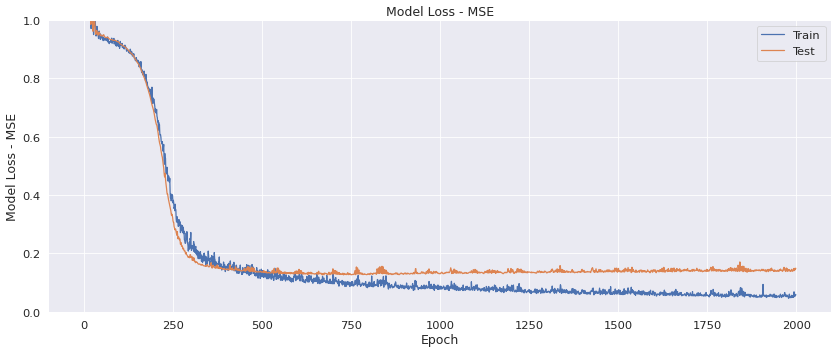

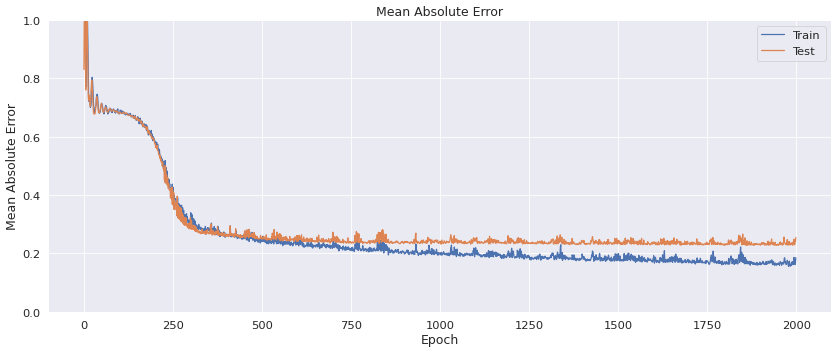

In [181]:
# Plot train vs test loss during training
plot_results(history.history['loss'], history.history['val_loss'], 1, 'Model Loss - MSE')

# Plot train vs test accuracy during training
plot_results(history.history['mae'], history.history['val_mae'], 1, 'Mean Absolute Error')

In [182]:
print('Model Evaluation Loss: {:.3f}'.format(model.evaluate(X_valid, y_valid)[0]))

19/19 [==============================] - 0s 853us/step - loss: 0.1492 - mae: 0.2547 - mse: 0.1492
Model Evaluation Loss: 0.149


Load the weights if no earlystopping

In [183]:
model.load_weights('../model/best_model.hdf5')
model.evaluate(X_valid, y_valid)

19/19 [==============================] - 0s 1ms/step - loss: 0.1263 - mae: 0.2352 - mse: 0.1263


[0.12634193897247314, 0.23521891236305237, 0.12634193897247314]

### Preparing Kaggle Submission file

In [184]:
predict_features = np.array(X_test)
y_test = targetScalar.inverse_transform(model.predict(predict_features))

In [185]:
submission.SalePrice = y_test.flatten()
submission.to_csv('../output/submission.csv', index=False) 

---
## Peer Comparison
Checking against data submission found here:
- https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition/output?select=submission_regression1.csv

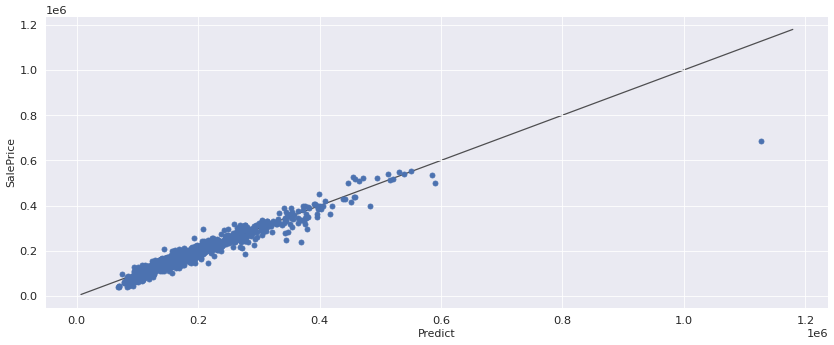

In [186]:
check = pd.read_csv(DATA_FOLDER + 'results.csv')
check['Predict'] = submission.SalePrice
plot_check(check, 'Predict', 'SalePrice')

In [187]:
from sklearn.metrics import mean_squared_error 
realVals = check.SalePrice
predictedVals = check.Predict
rmse = mean_squared_error(realVals, predictedVals, squared = False)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

print('VALIDATION_ERROR: {}'.format(hist.val_mse.min()))
print('NODES: {}'.format(NODES))
print('LR: {}'.format(LR))
print('ACTIVATION: {}'.format(ACTIVATION))
print('BATCH_SIZE: {}'.format(BATCH_SIZE))
print('INPUT_DROPOUT: {}'.format(INPUT_DROPOUT))
print('EPOCHS: {}'.format(EPOCHS))
print('PATIENCE: {}'.format(PATIENCE))
print('RMSE: {}'.format(rmse))

VALIDATION_ERROR: 0.12634193897247314
NODES: (16, 32, 64)
LR: 0.0005
ACTIVATION: relu
BATCH_SIZE: 874
INPUT_DROPOUT: 0.051
EPOCHS: 2000
PATIENCE: 2000
RMSE: 20936.482879514584


### Hyperparameter search on peer comparison data

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error 

check = pd.read_csv(DATA_FOLDER + 'results.csv')

results = []

NODES_LIST = [(16, 16, 16), (16, 16, 32), (16, 16, 64), (16, 32, 16), (16, 32, 32), 
              (16, 32, 64), (16, 64, 16), (16, 64, 32), (16, 64, 64), (32, 16, 16), 
              (32, 16, 32), (32, 16, 64), (32, 32, 16), (32, 32, 32), (32, 32, 64), 
              (32, 64, 16), (32, 64, 32), (32, 64, 64), (64, 16, 16), (64, 16, 32), 
              (64, 16, 64), (64, 32, 16), (64, 32, 32), (64, 32, 64), (64, 64, 16), 
              (64, 64, 32), (64, 64, 64)]
LRs = [0.0005, 0.001]
ACTIVATIONs = ['relu']
EPOCHS_LIST = [2000]
INPUTDROPOUT_LIST = [.2, 0.1, 0.05]
PATIENCE = 2000

for NODE in tqdm(NODES_LIST):
    for LR in tqdm(LRs):
        for ACTIVATION in tqdm(ACTIVATIONs):
            for EPOCHS in tqdm(EPOCHS_LIST):
                for INPUT_DROPOUT in tqdm(INPUTDROPOUT_LIST):
                    result = {}

                    PATIENCE = EPOCHS
                    
                    bestmodel_earlystop = EarlyStopping(monitor='val_mse', 
                                                    patience=PATIENCE, 
                                                    restore_best_weights=True)

                    #'model-{epoch:03d}-{loss:03f}-{val_loss:03f}.hdf5'
                    bestmodel_chkpt = ModelCheckpoint('../model/search_best_model.hdf5', 
                                                           monitor='val_loss', 
                                                           save_best_only=True, mode='min')
                    
                    CALLBACKS = [bestmodel_chkpt, bestmodel_earlystop]

                    model = build_model(nodes=NODE, activation=ACTIVATION, 
                                        learning_rate=LR, input_dropout=INPUT_DROPOUT)
                    history = model.fit(X_train, y_train, epochs=EPOCHS, 
                                        validation_data=(X_valid, y_valid), 
                                        batch_size=BATCH_SIZE, verbose=0, 
                                        callbacks=CALLBACKS)

                    hist = pd.DataFrame(history.history)
                    hist['bestepoch'] = history.epoch

                    result['node'] = NODE
                    result['learningrate'] = LR
                    result['activation'] = ACTIVATION
                    result['batchsize'] = BATCH_SIZE
                    result['inputdropout'] = INPUT_DROPOUT
                    result['epochs'] = EPOCHS
                    result['loss'] = hist.val_mse.min()
                    result['earlystopped'] = history.epoch < EPOCHS 

#                     try:
#                         model.load_weights('../model/search_best_model.hdf5')
#                     except:
#                         print('No Saved Model!')
#                         pass

                    y_predict = targetScalar.inverse_transform(model.predict(np.array(X_test))).flatten()
                    result['rmse'] = mean_squared_error(check.SalePrice, y_predict, squared = False)

                    results.append(result)

In [ ]:
pd.DataFrame(results).sort_values('rmse')

In [ ]:
pd.DataFrame(results).sort_values('rmse')